# Task 2 Multiclass classification Baseline

In this class, we will develop a baseline for Task 2 using the chess dataset. We will model the task as an multiclass classification task.

In [1]:
import matplotlib.pyplot as plt, numpy as np, os, torch, random, cv2, json
from torch import nn
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torchvision import models
from torchvision.transforms import v2 as transforms
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from PIL import Image

random.seed(42)

### Connect Colab to Drive (if the dataset is on drive)

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
#!unzip "drive/MyDrive/Dataset/images.zip" -d "."
#!cp "drive/MyDrive/Dataset/annotations.json" -d "."

In [4]:
# Define the model
# Define model
#weights = models.ResNet50_Weights.IMAGENET1K_V2
#model = models.resnet50(weights=weights)
#transforms = weights.transforms()
weights = models.ResNet152_Weights.IMAGENET1K_V2
model = models.resnet152(weights=weights)
transforms = weights.transforms()

## Load dataset

**Tip**: since the images are very big, resize the dataset before loading it to save time and memory during training (use cubic interpolation to preserve image quality when downsizing the images)!

In [5]:
# Normalize images
data_aug = transforms
"""transforms.Compose([
    transforms.ToImage(),
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])"""

data_in = transforms
"""transforms.Compose([
    transforms.ToImage(),
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])"""

'transforms.Compose([\n    transforms.ToImage(),\n    transforms.Resize((256, 256)),\n    transforms.CenterCrop((224, 224)),\n    transforms.ToDtype(torch.float32, scale=True),\n    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])\n])'

In [6]:
def chesspos2number(chesspos):
    col = ord(chesspos[0])-ord('a')
    col = 7-col
    row = int(chesspos[1])-1
    return row, col

class ChessDataset(Dataset):
    def __init__(self, root_dir, partition, transform=None):
        self.anns = json.load(open(os.path.join(root_dir, 'annotations.json')))
        self.categories = [c['name'] for c in self.anns['categories']]
        self.root = root_dir
        self.ids = []
        self.file_names = []
        for x in self.anns['images']:
            self.file_names.append(x['path'])
            self.ids.append(x['id'])
        self.file_names = np.asarray(self.file_names)
        #restrict ther the number of filenames to 10
        self.ids = np.asarray(self.ids)
        self.boards=torch.full((len(self.file_names), 8 * 8), 12)
        for piece in self.anns['annotations']['pieces']:
            idx = np.where(self.ids == piece['image_id'])[0][0]
            row, col = chesspos2number(piece['chessboard_position'])
            piceId =piece['category_id']
            self.boards[idx][row*8+col] = piceId
        #print(self.boards[0])
        if partition == 'train':#['chessred2k']
            self.split_ids = np.asarray(self.anns['splits']['train']['image_ids']).astype(int)
        elif partition == 'valid':
            self.split_ids = np.asarray(self.anns['splits']['val']['image_ids']).astype(int)
        else:
            self.split_ids = np.asarray(self.anns['splits']['test']['image_ids']).astype(int)

        intersect = np.isin(self.ids, self.split_ids)
        self.split_ids = np.where(intersect)[0]
        self.file_names = self.file_names[self.split_ids]
        self.file_names = self.file_names[:45]
        #self.boards = self.boards[self.split_ids]
        self.ids = self.ids[self.split_ids]

        self.transform = transform
        print(f"Number of {partition} images: {len(self.file_names)}")
        self.images = {}
        for i in range(len(self.file_names)):
            #image = cv2.imread(os.path.join(self.root, self.file_names[i]))
            #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = Image.open(os.path.join(self.root, self.file_names[i]))
            if self.transform:
                image = self.transform(image)
            self.images[self.file_names[i]] = image

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, i):
        image = self.images[self.file_names[i]]

        board = self.boards[self.split_ids[i]]
        #print("Board shape:",board.shape)
        return image, board

train_dataset = ChessDataset('..', 'train', data_aug)
valid_dataset = ChessDataset('..', 'valid', data_in)
test_dataset = ChessDataset('..', 'test', data_in)

Number of train images: 45
Number of valid images: 45
Number of test images: 45


In [7]:
# get cpu or gpu device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# now we need to define a Dataloader, which allows us to automatically batch our inputs, do sampling and multiprocess data loading
batch_size = 15
num_workers = 0 # how many processes are used to load the data

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)

Using cuda device


In [9]:
def print_readable_board(labels):
    piece_dict = {
    0: "P",
    1: "R",
    2: "N",
    3: "B",
    4: "Q",
    5: "K",
    6: "p",
    7: "r",
    8: "n",
    9: "b",
    10:"q",
    11: "k",
    12: "-"
}
    for i in range(8):
        result_tmp = []
        for j in range(8):
            #print(labels[i*8+j].item())
            result_tmp.append(piece_dict[labels[i*8+j].item()])
        print(result_tmp)

['R', '-', '-', 'K', 'Q', 'B', '-', 'R']
['P', 'B', '-', '-', 'N', 'P', 'P', 'P']
['-', 'P', 'N', '-', 'P', '-', '-', '-']
['-', '-', 'P', 'P', '-', '-', '-', '-']
['-', '-', '-', '-', 'p', 'p', '-', '-']
['-', 'p', '-', 'p', '-', 'n', '-', '-']
['p', 'b', 'p', 'n', '-', '-', 'p', 'p']
['r', '-', '-', 'k', 'q', 'b', '-', 'r']


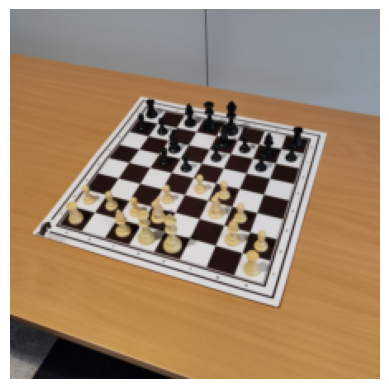

['R', 'N', 'B', 'K', 'Q', 'B', 'N', 'R']
['P', 'P', 'P', 'P', 'P', 'P', '-', 'P']
['-', '-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', 'P', '-']
['-', '-', '-', '-', '-', '-', '-', '-']
['-', '-', '-', '-', '-', '-', '-', '-']
['p', 'p', 'p', 'p', 'p', 'p', 'p', 'p']
['r', 'n', 'b', 'k', 'q', 'b', 'n', 'r']


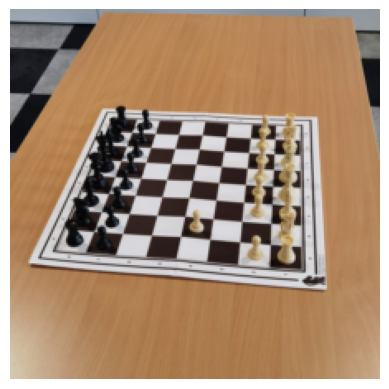

In [10]:
for batch in train_dataloader:
    # Get images of the batch and print their dimensions
    imgs = batch[0]
    imgs = imgs.permute(0, 2, 3, 1)*torch.tensor([[[0.229, 0.224, 0.225]]]) + torch.tensor([[[0.485, 0.456, 0.406]]])

    # Get labels of each image in the batch and print them
    labels = batch[1]
    #print(labels[0].shape)
    #print(labels[0])
    print_readable_board(labels[0])
    #print(torch.argmax(labels[0])+1)

    # Show first image of the batch
    plt.imshow(imgs[0])
    plt.axis('off')
    plt.show()

    break
for batch in test_dataloader:
    # Get images of the batch and print their dimensions
    imgs = batch[0]
    imgs = imgs.permute(0, 2, 3, 1)*torch.tensor([[[0.229, 0.224, 0.225]]]) + torch.tensor([[[0.485, 0.456, 0.406]]])
    #print(imgs.shape)

    # Get labels of each image in the batch and print them
    labels = batch[1]
    #print(labels[1])
    print_readable_board(labels[1])
    #print(torch.argmax(labels[0])+1)

    # Show first image of the batch
    plt.imshow(imgs[1])
    plt.axis('off')
    plt.show()

    break

## Defining the model

We will use a pre-trained ResNet50 network.

  1: white-pawn
  2: white-pawn
  3: white-pawn
  4: white-pawn
  5: white-pawn
  6: white-pawn
  7: white-pawn
  8: white-pawn
  9: white-rook
  10: white-rook
  11: white-knight
  12: white-knight
  13: white-bishop
  14: white-bishop
  15: white-queen
  16: white-king
  17: black-pawn
  18: black-pawn
  19: black-pawn
  20: black-pawn
  21: black-pawn
  22: black-pawn
  23: black-pawn
  24: black-pawn
  25: black-rook
  26: black-rook
  27: black-knight
  28: black-knight
  29: black-bishop
  30: black-bishop
  31: black-king
  32: black-queen
  12: empty

In [11]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


#for param in model:
#    param.requires_grad = False
# change the number of neurons in the last layer to the number of classes of the problem at hand (maximum number of pieces on a chess game)
# TODO
# MLP
size_parameters = 512
model.fc = nn.Sequential(
    #nn.Linear(model.fc.in_features, size_parameters),
    #nn.ReLU(),
    #nn.Linear(size_parameters, size_parameters),
    #nn.ReLU(),
    #nn.Linear(size_parameters, size_parameters),
    #nn.ReLU(),
    nn.Linear(model.fc.in_features, 64),
    nn.Sigmoid()
)
# black 
model.to(device)

Using cuda device


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
from sklearn.metrics import mean_absolute_error,mean_squared_error, f1_score,accuracy_score,recall_score,precision_score
def calculate_metrics(all_preds, all_labels):
    # claculate the accuracy of all the board
    accuracy_list = []
    for i in range(all_preds.shape[0]):
      #print("Test3",all_preds[i].shape)
      #print("\n")
      correct = (all_preds[i] == all_labels[i]).sum().item()
      total = all_labels[i].numel()
      #print((all_preds[i] == all_labels[i]))
      #print("Testing:",correct,"\nTotal:",total)
      accuracy_list.append(correct == total)
    accuracy = np.mean(accuracy_list)
    #for i in range(all_preds.shape[0]):
    all_preds = (all_preds.detach().numpy()*12).round().astype(int)
    all_labels = all_labels.detach().numpy()
    #print("Test1 :",all_labels.flatten().shape, all_preds.flatten().shape)
    recall = recall_score(all_labels.flatten(), all_preds.flatten(), average='macro')
    precision = precision_score(all_labels.flatten(), all_preds.flatten(), average='macro')
    f1 = f1_score(all_labels.flatten(), all_preds.flatten(), average='macro')
    return accuracy, recall, precision, f1

## Train the model

Define function to perform one iteration

In [13]:
from sklearn.metrics import mean_absolute_error,mean_squared_error, f1_score,accuracy_score

def epoch_iter(dataloader, model, loss_fn, optimizer=None, is_train=True):
    if is_train:
      assert optimizer is not None, "When training, please provide an optimizer."
      
    num_batches = len(dataloader)

    if is_train:
      model.train() # put model in train mode
    else:
      model.eval()

    total_loss = 0.0
    preds = []
    labels = []

    with torch.set_grad_enabled(is_train):
      for batch, (X, y) in enumerate(tqdm(dataloader)):
          X, y = X.to(device), y.to(device).float() # remove the last dimension
        
          # Compute prediction error
          
          pred = model(X)
          scaled_pred = (pred * 12)#.round() # Scale [0,1] → [1,32]
          #scaled_pred = model(X)
          #print(scaled_pred.shape,y.shape)
          #print(scaled_pred,y)
          loss = loss_fn(scaled_pred, y)

          if is_train:
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
          # Save training metrics
          total_loss += loss.item() # IMPORTANT: call .item() to obtain the value of the loss WITHOUT the computational graph attached

          preds.append(scaled_pred.cpu())
          #print(preds)
          #print(final_pred.cpu().numpy())
          #original_values =y.cpu().argmax(dim=-1) + 1
          labels.append(y.cpu())
    all_preds = torch.cat(preds).round()
    all_labels = torch.cat(labels)
    print("Scaled pred:",all_preds)
    print("Y:",all_preds)
    #print("All preds shape:",all_preds.shape)
    #print("All labels shape:",all_labels.shape)
    accuracy, recall, precision, f1 = calculate_metrics(all_preds, all_labels)
    #print("Mean Correct: :",matches)
    """print(all_preds.shape,all_labels.shape)
    print(all_preds,all_labels)
      # Calculate exact match accuracy (PyTorch way)
    exact_matches = (all_preds == all_labels).all(dim=1).float().mean().item()
    
    # Calculate element-wise accuracy
    element_acc = (all_preds == all_labels).float().mean().item()
    print(exact_matches,element_acc)"""
    
    return total_loss / num_batches, accuracy, recall, precision, f1

Define function to train a model

In [14]:
def train(model, model_name, num_epochs, train_dataloader, validation_dataloader, loss_fn, optimizer):
  train_history = {'loss': [], 'accuracy': [], 'recall':[], 'precision': [], 'f1': []}
  val_history = {'loss': [], 'accuracy': [], 'recall':[], 'precision': [], 'f1': []}
  best_val_loss = np.inf
  print("Start training...")
  for t in range(num_epochs):
      print(f"\nEpoch {t+1}")
      train_loss, train_acc,train_recall,train_precision,train_f1 = epoch_iter(train_dataloader, model, loss_fn, optimizer)
      print(f"Train loss: {train_loss:.5f} \t Train acc: {train_acc:.5f} \t Train recall: {train_recall:.5f} \t Train precision: {train_precision:.5f} \t Train f1: {train_f1:.5f}")
      val_loss, val_acc,val_recall,val_precision,val_f1 = epoch_iter(validation_dataloader, model, loss_fn, is_train=False)
      print(f"Val loss: {val_loss:.5f} \t Val acc: {val_acc:.5f} \t Val recall: {val_recall:.5f} \t Val precision: {val_precision:.5f} \t Val f1: {val_f1:.5f}")

      # save model when val loss improves
      if val_loss < best_val_loss:
        best_val_loss = val_loss
        save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
        torch.save(save_dict, model_name + '_best_model.pth')

      # save latest model
      save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
      torch.save(save_dict, model_name + '_latest_model.pth')

      # save training history for plotting purposes
      train_history["loss"].append(train_loss)
      train_history["accuracy"].append(train_acc)
      train_history["recall"].append(train_recall)
      train_history["precision"].append(train_precision)
      train_history["f1"].append(train_f1)

      val_history["loss"].append(val_loss)
      val_history["accuracy"].append(val_acc)
      val_history["recall"].append(val_recall)
      val_history["precision"].append(val_precision)
      val_history["f1"].append(val_f1)
      
  print("Finished")
  return train_history, val_history

Define loss, optimizer and train the model

In [ ]:
# Define loss function
#loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.MSELoss()
# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
num_epochs = 100

# TODO - Train the model
train_history, val_history = train(model, 'chess_model', num_epochs, train_dataloader, valid_dataloader, loss_fn, optimizer)

Start training...

Epoch 1


100%|██████████| 3/3 [00:01<00:00,  2.83it/s]
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Scaled pred: tensor([[ 6.,  6.,  6.,  ...,  7.,  6.,  7.],
        [ 5.,  6.,  6.,  ...,  7.,  6.,  7.],
        [ 6.,  6.,  6.,  ...,  7.,  7.,  6.],
        ...,
        [ 4.,  9.,  2.,  ...,  9., 10., 10.],
        [ 3., 10.,  2.,  ..., 10., 10., 10.],
        [ 5.,  9.,  3.,  ...,  8.,  9.,  9.]], grad_fn=<RoundBackward0>)
Y: tensor([[ 6.,  6.,  6.,  ...,  7.,  6.,  7.],
        [ 5.,  6.,  6.,  ...,  7.,  6.,  7.],
        [ 6.,  6.,  6.,  ...,  7.,  7.,  6.],
        ...,
        [ 4.,  9.,  2.,  ...,  9., 10., 10.],
        [ 3., 10.,  2.,  ..., 10., 10., 10.],
        [ 5.,  9.,  3.,  ...,  8.,  9.,  9.]], grad_fn=<RoundBackward0>)
Test1 : (2880,) (2880,)
Train loss: 18.66433 	 Train acc: 0.00000 	 Train recall: 0.00000 	 Train precision: 0.00000 	 Train f1: 0.00000


100%|██████████| 3/3 [00:00<00:00, 13.28it/s]
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Scaled pred: tensor([[ 3., 10.,  1.,  ..., 11., 11., 11.],
        [ 4., 10.,  1.,  ..., 11., 11., 10.],
        [ 3., 11.,  0.,  ..., 11., 11., 11.],
        ...,
        [ 3., 11.,  1.,  ..., 11., 11., 10.],
        [ 4., 10.,  2.,  ..., 11., 10., 10.],
        [ 4., 10.,  2.,  ..., 10., 10., 10.]])
Y: tensor([[ 3., 10.,  1.,  ..., 11., 11., 11.],
        [ 4., 10.,  1.,  ..., 11., 11., 10.],
        [ 3., 11.,  0.,  ..., 11., 11., 11.],
        ...,
        [ 3., 11.,  1.,  ..., 11., 11., 10.],
        [ 4., 10.,  2.,  ..., 11., 10., 10.],
        [ 4., 10.,  2.,  ..., 10., 10., 10.]])
Test1 : (2880,) (2880,)
Val loss: 25.09924 	 Val acc: 0.00000 	 Val recall: 0.00194 	 Val precision: 0.02886 	 Val f1: 0.00359

Epoch 2


100%|██████████| 3/3 [00:00<00:00,  4.22it/s]
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Scaled pred: tensor([[ 4., 10.,  1.,  ..., 11., 11., 11.],
        [ 3., 10.,  1.,  ..., 11., 11., 11.],
        [ 5.,  9.,  4.,  ...,  9.,  9.,  8.],
        ...,
        [ 4., 11.,  2.,  ..., 11., 10., 10.],
        [ 6., 10.,  2.,  ..., 11., 10.,  9.],
        [ 4.,  9.,  3.,  ..., 10., 10.,  8.]], grad_fn=<RoundBackward0>)
Y: tensor([[ 4., 10.,  1.,  ..., 11., 11., 11.],
        [ 3., 10.,  1.,  ..., 11., 11., 11.],
        [ 5.,  9.,  4.,  ...,  9.,  9.,  8.],
        ...,
        [ 4., 11.,  2.,  ..., 11., 10., 10.],
        [ 6., 10.,  2.,  ..., 11., 10.,  9.],
        [ 4.,  9.,  3.,  ..., 10., 10.,  8.]], grad_fn=<RoundBackward0>)
Test1 : (2880,) (2880,)
Train loss: 8.65290 	 Train acc: 0.00000 	 Train recall: 0.00307 	 Train precision: 0.03136 	 Train f1: 0.00560


100%|██████████| 3/3 [00:00<00:00, 13.76it/s]
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Scaled pred: tensor([[ 4., 11.,  1.,  ..., 11., 10.,  9.],
        [ 4., 11.,  1.,  ..., 11., 10.,  9.],
        [ 4., 10.,  1.,  ..., 11.,  9.,  8.],
        ...,
        [ 6., 11.,  1.,  ..., 11., 11.,  9.],
        [ 4., 11.,  1.,  ..., 11., 10.,  9.],
        [ 4., 11.,  1.,  ..., 11., 10., 10.]])
Y: tensor([[ 4., 11.,  1.,  ..., 11., 10.,  9.],
        [ 4., 11.,  1.,  ..., 11., 10.,  9.],
        [ 4., 10.,  1.,  ..., 11.,  9.,  8.],
        ...,
        [ 6., 11.,  1.,  ..., 11., 11.,  9.],
        [ 4., 11.,  1.,  ..., 11., 10.,  9.],
        [ 4., 11.,  1.,  ..., 11., 10., 10.]])
Test1 : (2880,) (2880,)
Val loss: 26.70878 	 Val acc: 0.00000 	 Val recall: 0.00599 	 Val precision: 0.03272 	 Val f1: 0.00962

Epoch 3


100%|██████████| 3/3 [00:00<00:00,  4.42it/s]
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Scaled pred: tensor([[ 5., 11.,  1.,  ..., 11., 11.,  9.],
        [ 6., 10.,  1.,  ..., 11., 11.,  9.],
        [ 5., 11.,  1.,  ..., 11., 11.,  9.],
        ...,
        [ 7., 10.,  1.,  ..., 11., 10.,  9.],
        [ 7.,  9.,  1.,  ..., 10., 10.,  8.],
        [ 6., 11.,  0.,  ..., 12., 11.,  9.]], grad_fn=<RoundBackward0>)
Y: tensor([[ 5., 11.,  1.,  ..., 11., 11.,  9.],
        [ 6., 10.,  1.,  ..., 11., 11.,  9.],
        [ 5., 11.,  1.,  ..., 11., 11.,  9.],
        ...,
        [ 7., 10.,  1.,  ..., 11., 10.,  9.],
        [ 7.,  9.,  1.,  ..., 10., 10.,  8.],
        [ 6., 11.,  0.,  ..., 12., 11.,  9.]], grad_fn=<RoundBackward0>)
Test1 : (2880,) (2880,)
Train loss: 6.49767 	 Train acc: 0.00000 	 Train recall: 0.00867 	 Train precision: 0.03344 	 Train f1: 0.01374


100%|██████████| 3/3 [00:00<00:00, 13.67it/s]
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Scaled pred: tensor([[ 2., 12.,  1.,  ..., 12., 11.,  9.],
        [ 2., 12.,  0.,  ..., 12., 11.,  8.],
        [ 5., 11.,  0.,  ..., 12., 10.,  7.],
        ...,
        [ 5., 12.,  1.,  ..., 11.,  9.,  8.],
        [ 2., 12.,  0.,  ..., 12., 11.,  9.],
        [ 5., 12.,  1.,  ..., 12., 10., 10.]])
Y: tensor([[ 2., 12.,  1.,  ..., 12., 11.,  9.],
        [ 2., 12.,  0.,  ..., 12., 11.,  8.],
        [ 5., 11.,  0.,  ..., 12., 10.,  7.],
        ...,
        [ 5., 12.,  1.,  ..., 11.,  9.,  8.],
        [ 2., 12.,  0.,  ..., 12., 11.,  9.],
        [ 5., 12.,  1.,  ..., 12., 10., 10.]])
Test1 : (2880,) (2880,)
Val loss: 28.76004 	 Val acc: 0.00000 	 Val recall: 0.00701 	 Val precision: 0.02436 	 Val f1: 0.00894

Epoch 4


100%|██████████| 3/3 [00:00<00:00,  4.29it/s]
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Scaled pred: tensor([[ 7., 11.,  0.,  ..., 11.,  9., 10.],
        [ 6., 11.,  1.,  ..., 11., 11.,  8.],
        [ 6., 11.,  2.,  ..., 11.,  9.,  9.],
        ...,
        [ 4., 11.,  1.,  ..., 11., 10.,  8.],
        [ 4., 12.,  1.,  ..., 12., 10., 10.],
        [ 1., 11.,  2.,  ..., 11., 10.,  5.]], grad_fn=<RoundBackward0>)
Y: tensor([[ 7., 11.,  0.,  ..., 11.,  9., 10.],
        [ 6., 11.,  1.,  ..., 11., 11.,  8.],
        [ 6., 11.,  2.,  ..., 11.,  9.,  9.],
        ...,
        [ 4., 11.,  1.,  ..., 11., 10.,  8.],
        [ 4., 12.,  1.,  ..., 12., 10., 10.],
        [ 1., 11.,  2.,  ..., 11., 10.,  5.]], grad_fn=<RoundBackward0>)
Test1 : (2880,) (2880,)
Train loss: 4.72076 	 Train acc: 0.00000 	 Train recall: 0.01935 	 Train precision: 0.03366 	 Train f1: 0.02414


100%|██████████| 3/3 [00:00<00:00, 13.16it/s]
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Scaled pred: tensor([[ 0., 11.,  1.,  ..., 11.,  9.,  8.],
        [ 0., 11.,  1.,  ..., 11., 10.,  8.],
        [ 2., 10.,  2.,  ..., 11.,  9.,  6.],
        ...,
        [ 1., 12.,  1.,  ..., 12., 10., 10.],
        [ 0., 12.,  1.,  ..., 12., 10.,  9.],
        [ 0., 12.,  1.,  ..., 12.,  9.,  9.]])
Y: tensor([[ 0., 11.,  1.,  ..., 11.,  9.,  8.],
        [ 0., 11.,  1.,  ..., 11., 10.,  8.],
        [ 2., 10.,  2.,  ..., 11.,  9.,  6.],
        ...,
        [ 1., 12.,  1.,  ..., 12., 10., 10.],
        [ 0., 12.,  1.,  ..., 12., 10.,  9.],
        [ 0., 12.,  1.,  ..., 12.,  9.,  9.]])
Test1 : (2880,) (2880,)
Val loss: 28.65234 	 Val acc: 0.00000 	 Val recall: 0.00878 	 Val precision: 0.02517 	 Val f1: 0.01092

Epoch 5


100%|██████████| 3/3 [00:00<00:00,  4.28it/s]
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Scaled pred: tensor([[ 4., 12.,  0.,  ..., 12.,  8., 11.],
        [ 2., 11.,  3.,  ..., 11., 10.,  6.],
        [ 6., 11.,  1.,  ..., 11.,  8.,  9.],
        ...,
        [ 8.,  9.,  2.,  ..., 10.,  8.,  9.],
        [ 3., 11.,  3.,  ..., 10.,  8.,  7.],
        [ 4., 10.,  2.,  ..., 10.,  7.,  9.]], grad_fn=<RoundBackward0>)
Y: tensor([[ 4., 12.,  0.,  ..., 12.,  8., 11.],
        [ 2., 11.,  3.,  ..., 11., 10.,  6.],
        [ 6., 11.,  1.,  ..., 11.,  8.,  9.],
        ...,
        [ 8.,  9.,  2.,  ..., 10.,  8.,  9.],
        [ 3., 11.,  3.,  ..., 10.,  8.,  7.],
        [ 4., 10.,  2.,  ..., 10.,  7.,  9.]], grad_fn=<RoundBackward0>)
Test1 : (2880,) (2880,)
Train loss: 4.07442 	 Train acc: 0.00000 	 Train recall: 0.02037 	 Train precision: 0.03397 	 Train f1: 0.02526


100%|██████████| 3/3 [00:00<00:00, 13.64it/s]
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Scaled pred: tensor([[ 1., 10.,  4.,  ..., 10.,  7.,  8.],
        [ 1., 10.,  4.,  ..., 10.,  7.,  9.],
        [ 1.,  9.,  4.,  ..., 10.,  8.,  7.],
        ...,
        [ 1., 11.,  3.,  ..., 11.,  8., 10.],
        [ 1., 10.,  3.,  ..., 11.,  7.,  9.],
        [ 1., 10.,  4.,  ..., 10.,  7.,  9.]])
Y: tensor([[ 1., 10.,  4.,  ..., 10.,  7.,  8.],
        [ 1., 10.,  4.,  ..., 10.,  7.,  9.],
        [ 1.,  9.,  4.,  ..., 10.,  8.,  7.],
        ...,
        [ 1., 11.,  3.,  ..., 11.,  8., 10.],
        [ 1., 10.,  3.,  ..., 11.,  7.,  9.],
        [ 1., 10.,  4.,  ..., 10.,  7.,  9.]])
Test1 : (2880,) (2880,)
Val loss: 26.84363 	 Val acc: 0.00000 	 Val recall: 0.00758 	 Val precision: 0.02962 	 Val f1: 0.01071

Epoch 6


100%|██████████| 3/3 [00:00<00:00,  4.41it/s]
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Scaled pred: tensor([[ 8.,  8.,  2.,  ..., 10., 10.,  8.],
        [ 3., 12.,  1.,  ..., 11.,  9.,  9.],
        [ 4., 11.,  2.,  ..., 11.,  9.,  9.],
        ...,
        [ 5., 12.,  0.,  ..., 12., 10., 10.],
        [ 5., 12.,  1.,  ..., 12., 11.,  9.],
        [ 9.,  8.,  2.,  ...,  9., 10.,  9.]], grad_fn=<RoundBackward0>)
Y: tensor([[ 8.,  8.,  2.,  ..., 10., 10.,  8.],
        [ 3., 12.,  1.,  ..., 11.,  9.,  9.],
        [ 4., 11.,  2.,  ..., 11.,  9.,  9.],
        ...,
        [ 5., 12.,  0.,  ..., 12., 10., 10.],
        [ 5., 12.,  1.,  ..., 12., 11.,  9.],
        [ 9.,  8.,  2.,  ...,  9., 10.,  9.]], grad_fn=<RoundBackward0>)
Test1 : (2880,) (2880,)
Train loss: 2.62878 	 Train acc: 0.00000 	 Train recall: 0.02459 	 Train precision: 0.03306 	 Train f1: 0.02811


100%|██████████| 3/3 [00:00<00:00, 12.99it/s]
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Scaled pred: tensor([[ 1., 10.,  4.,  ..., 10.,  9.,  8.],
        [ 1., 10.,  4.,  ...,  9.,  9.,  9.],
        [ 2.,  7.,  4.,  ...,  8.,  9.,  7.],
        ...,
        [ 3., 12.,  1.,  ..., 12., 10., 10.],
        [ 1., 10.,  3.,  ..., 10.,  9.,  9.],
        [ 1., 11.,  2.,  ..., 11., 10., 10.]])
Y: tensor([[ 1., 10.,  4.,  ..., 10.,  9.,  8.],
        [ 1., 10.,  4.,  ...,  9.,  9.,  9.],
        [ 2.,  7.,  4.,  ...,  8.,  9.,  7.],
        ...,
        [ 3., 12.,  1.,  ..., 12., 10., 10.],
        [ 1., 10.,  3.,  ..., 10.,  9.,  9.],
        [ 1., 11.,  2.,  ..., 11., 10., 10.]])
Test1 : (2880,) (2880,)
Val loss: 28.11125 	 Val acc: 0.00000 	 Val recall: 0.00669 	 Val precision: 0.03079 	 Val f1: 0.00894

Epoch 7


100%|██████████| 3/3 [00:00<00:00,  4.27it/s]
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Scaled pred: tensor([[ 4., 12.,  1.,  ..., 12.,  7., 11.],
        [ 6., 11.,  1.,  ..., 11.,  7., 11.],
        [ 1., 11.,  4.,  ...,  9., 10.,  8.],
        ...,
        [ 6., 12.,  0.,  ..., 12., 12.,  6.],
        [ 6., 12.,  0.,  ..., 12., 10., 11.],
        [ 9.,  7.,  3.,  ...,  8., 10.,  8.]], grad_fn=<RoundBackward0>)
Y: tensor([[ 4., 12.,  1.,  ..., 12.,  7., 11.],
        [ 6., 11.,  1.,  ..., 11.,  7., 11.],
        [ 1., 11.,  4.,  ...,  9., 10.,  8.],
        ...,
        [ 6., 12.,  0.,  ..., 12., 12.,  6.],
        [ 6., 12.,  0.,  ..., 12., 10., 11.],
        [ 9.,  7.,  3.,  ...,  8., 10.,  8.]], grad_fn=<RoundBackward0>)
Test1 : (2880,) (2880,)
Train loss: 2.04904 	 Train acc: 0.00000 	 Train recall: 0.02618 	 Train precision: 0.03315 	 Train f1: 0.02914


100%|██████████| 3/3 [00:00<00:00, 13.22it/s]
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Scaled pred: tensor([[ 1., 11.,  5.,  ..., 10., 11.,  7.],
        [ 1., 10.,  5.,  ...,  9., 10.,  7.],
        [ 4.,  8.,  3.,  ...,  9., 10.,  6.],
        ...,
        [ 5., 11.,  2.,  ..., 11., 11.,  7.],
        [ 1., 10.,  3.,  ...,  8.,  9.,  8.],
        [ 2., 11.,  2.,  ..., 10., 10.,  9.]])
Y: tensor([[ 1., 11.,  5.,  ..., 10., 11.,  7.],
        [ 1., 10.,  5.,  ...,  9., 10.,  7.],
        [ 4.,  8.,  3.,  ...,  9., 10.,  6.],
        ...,
        [ 5., 11.,  2.,  ..., 11., 11.,  7.],
        [ 1., 10.,  3.,  ...,  8.,  9.,  8.],
        [ 2., 11.,  2.,  ..., 10., 10.,  9.]])
Test1 : (2880,) (2880,)
Val loss: 28.18147 	 Val acc: 0.00000 	 Val recall: 0.00702 	 Val precision: 0.03252 	 Val f1: 0.00950

Epoch 8


100%|██████████| 3/3 [00:00<00:00,  4.28it/s]
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Scaled pred: tensor([[ 1.,  3.,  3.,  ...,  8.,  9.,  7.],
        [ 6.,  7.,  2.,  ...,  7., 11.,  6.],
        [ 5., 11.,  1.,  ..., 11.,  7., 11.],
        ...,
        [ 5., 12.,  0.,  ..., 12., 12.,  7.],
        [ 6., 11.,  1.,  ..., 10.,  9.,  8.],
        [ 5., 12.,  1.,  ..., 12., 11.,  8.]], grad_fn=<RoundBackward0>)
Y: tensor([[ 1.,  3.,  3.,  ...,  8.,  9.,  7.],
        [ 6.,  7.,  2.,  ...,  7., 11.,  6.],
        [ 5., 11.,  1.,  ..., 11.,  7., 11.],
        ...,
        [ 5., 12.,  0.,  ..., 12., 12.,  7.],
        [ 6., 11.,  1.,  ..., 10.,  9.,  8.],
        [ 5., 12.,  1.,  ..., 12., 11.,  8.]], grad_fn=<RoundBackward0>)
Test1 : (2880,) (2880,)
Train loss: 1.72759 	 Train acc: 0.00000 	 Train recall: 0.02813 	 Train precision: 0.03338 	 Train f1: 0.03043


100%|██████████| 3/3 [00:00<00:00, 13.01it/s]
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Scaled pred: tensor([[ 1., 11.,  4.,  ..., 10., 10.,  7.],
        [ 1., 10.,  4.,  ...,  9., 10.,  7.],
        [ 6.,  9.,  2.,  ...,  9., 10.,  5.],
        ...,
        [ 5., 12.,  1.,  ..., 12., 12.,  7.],
        [ 1., 10.,  2.,  ...,  9.,  9.,  8.],
        [ 4., 12.,  1.,  ..., 11., 11.,  9.]])
Y: tensor([[ 1., 11.,  4.,  ..., 10., 10.,  7.],
        [ 1., 10.,  4.,  ...,  9., 10.,  7.],
        [ 6.,  9.,  2.,  ...,  9., 10.,  5.],
        ...,
        [ 5., 12.,  1.,  ..., 12., 12.,  7.],
        [ 1., 10.,  2.,  ...,  9.,  9.,  8.],
        [ 4., 12.,  1.,  ..., 11., 11.,  9.]])
Test1 : (2880,) (2880,)
Val loss: 28.47767 	 Val acc: 0.00000 	 Val recall: 0.00732 	 Val precision: 0.02893 	 Val f1: 0.00964

Epoch 9


100%|██████████| 3/3 [00:00<00:00,  3.42it/s]
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Scaled pred: tensor([[ 1., 10.,  6.,  ...,  8., 11.,  5.],
        [ 4., 12.,  0.,  ..., 12.,  6., 11.],
        [ 3., 12.,  1.,  ..., 12.,  6., 11.],
        ...,
        [ 7.,  9.,  1.,  ...,  9.,  9., 10.],
        [ 5., 12.,  0.,  ..., 12., 12.,  9.],
        [ 4., 12.,  0.,  ..., 12.,  4., 12.]], grad_fn=<RoundBackward0>)
Y: tensor([[ 1., 10.,  6.,  ...,  8., 11.,  5.],
        [ 4., 12.,  0.,  ..., 12.,  6., 11.],
        [ 3., 12.,  1.,  ..., 12.,  6., 11.],
        ...,
        [ 7.,  9.,  1.,  ...,  9.,  9., 10.],
        [ 5., 12.,  0.,  ..., 12., 12.,  9.],
        [ 4., 12.,  0.,  ..., 12.,  4., 12.]], grad_fn=<RoundBackward0>)
Test1 : (2880,) (2880,)
Train loss: 1.75242 	 Train acc: 0.00000 	 Train recall: 0.02945 	 Train precision: 0.03314 	 Train f1: 0.03119


100%|██████████| 3/3 [00:00<00:00, 14.40it/s]
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Scaled pred: tensor([[ 1., 11.,  3.,  ..., 10., 10.,  8.],
        [ 1., 10.,  4.,  ..., 10.,  9.,  8.],
        [ 6.,  9.,  1.,  ..., 10., 10.,  6.],
        ...,
        [ 8., 11.,  1.,  ..., 11., 11.,  8.],
        [ 2., 10.,  2.,  ...,  9.,  9.,  9.],
        [ 4., 11.,  1.,  ..., 11., 10., 10.]])
Y: tensor([[ 1., 11.,  3.,  ..., 10., 10.,  8.],
        [ 1., 10.,  4.,  ..., 10.,  9.,  8.],
        [ 6.,  9.,  1.,  ..., 10., 10.,  6.],
        ...,
        [ 8., 11.,  1.,  ..., 11., 11.,  8.],
        [ 2., 10.,  2.,  ...,  9.,  9.,  9.],
        [ 4., 11.,  1.,  ..., 11., 10., 10.]])
Test1 : (2880,) (2880,)
Val loss: 28.30093 	 Val acc: 0.00000 	 Val recall: 0.00731 	 Val precision: 0.03435 	 Val f1: 0.00989

Epoch 10


100%|██████████| 3/3 [00:00<00:00,  4.94it/s]
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Scaled pred: tensor([[ 3., 10.,  9.,  ...,  9., 11.,  7.],
        [ 9.,  8.,  0.,  ...,  9.,  8., 11.],
        [ 5., 12.,  1.,  ..., 11., 11.,  8.],
        ...,
        [ 1., 11.,  1.,  ..., 11.,  7.,  9.],
        [ 6., 12.,  1.,  ..., 12., 10., 11.],
        [ 1., 11.,  4.,  ...,  9., 11.,  6.]], grad_fn=<RoundBackward0>)
Y: tensor([[ 3., 10.,  9.,  ...,  9., 11.,  7.],
        [ 9.,  8.,  0.,  ...,  9.,  8., 11.],
        [ 5., 12.,  1.,  ..., 11., 11.,  8.],
        ...,
        [ 1., 11.,  1.,  ..., 11.,  7.,  9.],
        [ 6., 12.,  1.,  ..., 12., 10., 11.],
        [ 1., 11.,  4.,  ...,  9., 11.,  6.]], grad_fn=<RoundBackward0>)
Test1 : (2880,) (2880,)
Train loss: 1.08544 	 Train acc: 0.00000 	 Train recall: 0.02933 	 Train precision: 0.03367 	 Train f1: 0.03135


100%|██████████| 3/3 [00:00<00:00, 15.31it/s]
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Scaled pred: tensor([[ 2., 11.,  4.,  ..., 10., 10.,  8.],
        [ 1., 10.,  4.,  ..., 10.,  9.,  8.],
        [ 5., 11.,  1.,  ..., 11., 11.,  7.],
        ...,
        [ 6., 11.,  2.,  ..., 11., 11.,  8.],
        [ 3., 10.,  2.,  ...,  9.,  9.,  9.],
        [ 3., 11.,  3.,  ..., 10., 10.,  8.]])
Y: tensor([[ 2., 11.,  4.,  ..., 10., 10.,  8.],
        [ 1., 10.,  4.,  ..., 10.,  9.,  8.],
        [ 5., 11.,  1.,  ..., 11., 11.,  7.],
        ...,
        [ 6., 11.,  2.,  ..., 11., 11.,  8.],
        [ 3., 10.,  2.,  ...,  9.,  9.,  9.],
        [ 3., 11.,  3.,  ..., 10., 10.,  8.]])
Test1 : (2880,) (2880,)
Val loss: 28.59668 	 Val acc: 0.00000 	 Val recall: 0.00731 	 Val precision: 0.03314 	 Val f1: 0.00981

Epoch 11


100%|██████████| 3/3 [00:00<00:00,  4.93it/s]
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Scaled pred: tensor([[ 1., 12., 10.,  ..., 10., 11.,  8.],
        [ 6., 12.,  0.,  ..., 12., 11.,  9.],
        [ 2., 11., 10.,  ..., 10., 12.,  8.],
        ...,
        [ 1.,  5.,  2.,  ..., 10.,  8.,  7.],
        [ 3., 12.,  0.,  ..., 12.,  7., 12.],
        [ 5., 12.,  1.,  ..., 12.,  9., 12.]], grad_fn=<RoundBackward0>)
Y: tensor([[ 1., 12., 10.,  ..., 10., 11.,  8.],
        [ 6., 12.,  0.,  ..., 12., 11.,  9.],
        [ 2., 11., 10.,  ..., 10., 12.,  8.],
        ...,
        [ 1.,  5.,  2.,  ..., 10.,  8.,  7.],
        [ 3., 12.,  0.,  ..., 12.,  7., 12.],
        [ 5., 12.,  1.,  ..., 12.,  9., 12.]], grad_fn=<RoundBackward0>)
Test1 : (2880,) (2880,)
Train loss: 0.72341 	 Train acc: 0.00000 	 Train recall: 0.03177 	 Train precision: 0.03417 	 Train f1: 0.03293


100%|██████████| 3/3 [00:00<00:00, 15.38it/s]
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Scaled pred: tensor([[ 2., 12.,  4.,  ..., 10., 10.,  7.],
        [ 1., 11.,  5.,  ...,  9., 10.,  7.],
        [ 5., 11.,  1.,  ..., 11., 11.,  7.],
        ...,
        [ 3., 11.,  3.,  ..., 10., 10.,  7.],
        [ 2., 10.,  3.,  ...,  9.,  8.,  7.],
        [ 2., 11.,  4.,  ..., 10.,  9.,  8.]])
Y: tensor([[ 2., 12.,  4.,  ..., 10., 10.,  7.],
        [ 1., 11.,  5.,  ...,  9., 10.,  7.],
        [ 5., 11.,  1.,  ..., 11., 11.,  7.],
        ...,
        [ 3., 11.,  3.,  ..., 10., 10.,  7.],
        [ 2., 10.,  3.,  ...,  9.,  8.,  7.],
        [ 2., 11.,  4.,  ..., 10.,  9.,  8.]])
Test1 : (2880,) (2880,)
Val loss: 28.87393 	 Val acc: 0.00000 	 Val recall: 0.00761 	 Val precision: 0.03554 	 Val f1: 0.01010

Epoch 12


100%|██████████| 3/3 [00:00<00:00,  4.99it/s]
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Scaled pred: tensor([[ 5., 12.,  0.,  ..., 12., 12.,  8.],
        [ 1., 12.,  2.,  ..., 10.,  8.,  6.],
        [ 1., 12.,  5.,  ..., 10., 10.,  7.],
        ...,
        [ 5., 12.,  1.,  ..., 12., 11., 10.],
        [ 2., 11., 10.,  ...,  9., 11.,  7.],
        [ 1., 12.,  3.,  ...,  9.,  8.,  6.]], grad_fn=<RoundBackward0>)
Y: tensor([[ 5., 12.,  0.,  ..., 12., 12.,  8.],
        [ 1., 12.,  2.,  ..., 10.,  8.,  6.],
        [ 1., 12.,  5.,  ..., 10., 10.,  7.],
        ...,
        [ 5., 12.,  1.,  ..., 12., 11., 10.],
        [ 2., 11., 10.,  ...,  9., 11.,  7.],
        [ 1., 12.,  3.,  ...,  9.,  8.,  6.]], grad_fn=<RoundBackward0>)
Test1 : (2880,) (2880,)
Train loss: 0.62704 	 Train acc: 0.00000 	 Train recall: 0.03214 	 Train precision: 0.03424 	 Train f1: 0.03316


100%|██████████| 3/3 [00:00<00:00, 15.38it/s]
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Scaled pred: tensor([[ 2., 11.,  5.,  ...,  9., 10.,  7.],
        [ 1., 10.,  4.,  ...,  9., 10.,  7.],
        [ 5., 10.,  2.,  ..., 10., 10.,  5.],
        ...,
        [ 2., 11.,  4.,  ...,  9., 10.,  7.],
        [ 2., 10.,  3.,  ...,  8.,  8.,  7.],
        [ 2., 11.,  5.,  ...,  9.,  9.,  7.]])
Y: tensor([[ 2., 11.,  5.,  ...,  9., 10.,  7.],
        [ 1., 10.,  4.,  ...,  9., 10.,  7.],
        [ 5., 10.,  2.,  ..., 10., 10.,  5.],
        ...,
        [ 2., 11.,  4.,  ...,  9., 10.,  7.],
        [ 2., 10.,  3.,  ...,  8.,  8.,  7.],
        [ 2., 11.,  5.,  ...,  9.,  9.,  7.]])
Test1 : (2880,) (2880,)
Val loss: 27.57880 	 Val acc: 0.00000 	 Val recall: 0.00765 	 Val precision: 0.03917 	 Val f1: 0.01054

Epoch 13


100%|██████████| 3/3 [00:00<00:00,  4.51it/s]
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Scaled pred: tensor([[ 4., 12.,  1.,  ..., 12.,  6., 12.],
        [ 1., 11.,  2.,  ...,  8., 11.,  6.],
        [ 4., 12.,  1.,  ..., 12., 12.,  6.],
        ...,
        [ 5., 12.,  1.,  ..., 12., 12.,  6.],
        [11.,  5.,  1.,  ...,  8., 10.,  8.],
        [ 5., 12.,  1.,  ..., 12.,  9., 10.]], grad_fn=<RoundBackward0>)
Y: tensor([[ 4., 12.,  1.,  ..., 12.,  6., 12.],
        [ 1., 11.,  2.,  ...,  8., 11.,  6.],
        [ 4., 12.,  1.,  ..., 12., 12.,  6.],
        ...,
        [ 5., 12.,  1.,  ..., 12., 12.,  6.],
        [11.,  5.,  1.,  ...,  8., 10.,  8.],
        [ 5., 12.,  1.,  ..., 12.,  9., 10.]], grad_fn=<RoundBackward0>)
Test1 : (2880,) (2880,)
Train loss: 0.45030 	 Train acc: 0.00000 	 Train recall: 0.03568 	 Train precision: 0.03537 	 Train f1: 0.03552


100%|██████████| 3/3 [00:00<00:00, 14.41it/s]
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Scaled pred: tensor([[ 2., 11.,  5.,  ...,  8.,  9.,  7.],
        [ 1., 10.,  4.,  ...,  9., 10.,  8.],
        [ 4.,  8.,  3.,  ...,  9., 10.,  5.],
        ...,
        [ 2., 11.,  4.,  ...,  9.,  9.,  8.],
        [ 2., 10.,  3.,  ...,  8.,  8.,  7.],
        [ 2., 11.,  4.,  ...,  8.,  9.,  7.]])
Y: tensor([[ 2., 11.,  5.,  ...,  8.,  9.,  7.],
        [ 1., 10.,  4.,  ...,  9., 10.,  8.],
        [ 4.,  8.,  3.,  ...,  9., 10.,  5.],
        ...,
        [ 2., 11.,  4.,  ...,  9.,  9.,  8.],
        [ 2., 10.,  3.,  ...,  8.,  8.,  7.],
        [ 2., 11.,  4.,  ...,  8.,  9.,  7.]])
Test1 : (2880,) (2880,)
Val loss: 26.98391 	 Val acc: 0.00000 	 Val recall: 0.00735 	 Val precision: 0.03789 	 Val f1: 0.01019

Epoch 14


100%|██████████| 3/3 [00:00<00:00,  4.83it/s]
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Scaled pred: tensor([[ 6., 12.,  1.,  ..., 12.,  8., 11.],
        [ 2., 11.,  3.,  ...,  9.,  9.,  7.],
        [ 6., 12.,  1.,  ..., 12., 12.,  8.],
        ...,
        [11.,  3.,  1.,  ...,  9., 11.,  8.],
        [ 0., 12.,  3.,  ...,  9.,  7.,  8.],
        [ 4., 12.,  1.,  ..., 12., 12.,  7.]], grad_fn=<RoundBackward0>)
Y: tensor([[ 6., 12.,  1.,  ..., 12.,  8., 11.],
        [ 2., 11.,  3.,  ...,  9.,  9.,  7.],
        [ 6., 12.,  1.,  ..., 12., 12.,  8.],
        ...,
        [11.,  3.,  1.,  ...,  9., 11.,  8.],
        [ 0., 12.,  3.,  ...,  9.,  7.,  8.],
        [ 4., 12.,  1.,  ..., 12., 12.,  7.]], grad_fn=<RoundBackward0>)
Test1 : (2880,) (2880,)
Train loss: 0.48303 	 Train acc: 0.00000 	 Train recall: 0.03605 	 Train precision: 0.03553 	 Train f1: 0.03578


100%|██████████| 3/3 [00:00<00:00, 13.51it/s]
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Scaled pred: tensor([[ 1., 11.,  6.,  ...,  9.,  9.,  7.],
        [ 1., 10.,  4.,  ...,  9.,  9.,  8.],
        [ 4.,  8.,  3.,  ..., 10., 10.,  6.],
        ...,
        [ 1., 11.,  4.,  ...,  9.,  9.,  8.],
        [ 1., 10.,  3.,  ...,  8.,  7.,  8.],
        [ 1., 11.,  5.,  ...,  9.,  8.,  7.]])
Y: tensor([[ 1., 11.,  6.,  ...,  9.,  9.,  7.],
        [ 1., 10.,  4.,  ...,  9.,  9.,  8.],
        [ 4.,  8.,  3.,  ..., 10., 10.,  6.],
        ...,
        [ 1., 11.,  4.,  ...,  9.,  9.,  8.],
        [ 1., 10.,  3.,  ...,  8.,  7.,  8.],
        [ 1., 11.,  5.,  ...,  9.,  8.,  7.]])
Test1 : (2880,) (2880,)
Val loss: 26.72819 	 Val acc: 0.00000 	 Val recall: 0.00770 	 Val precision: 0.03780 	 Val f1: 0.01082

Epoch 15


100%|██████████| 3/3 [00:00<00:00,  4.78it/s]
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Scaled pred: tensor([[ 1., 12., 11.,  ...,  9., 12.,  7.],
        [ 5., 12.,  1.,  ..., 12.,  9., 11.],
        [ 4., 12.,  1.,  ..., 12., 12.,  8.],
        ...,
        [ 6., 12.,  1.,  ..., 11.,  7., 12.],
        [ 5., 12.,  2.,  ..., 12., 11.,  9.],
        [ 6., 12.,  1.,  ..., 12., 12.,  9.]], grad_fn=<RoundBackward0>)
Y: tensor([[ 1., 12., 11.,  ...,  9., 12.,  7.],
        [ 5., 12.,  1.,  ..., 12.,  9., 11.],
        [ 4., 12.,  1.,  ..., 12., 12.,  8.],
        ...,
        [ 6., 12.,  1.,  ..., 11.,  7., 12.],
        [ 5., 12.,  2.,  ..., 12., 11.,  9.],
        [ 6., 12.,  1.,  ..., 12., 12.,  9.]], grad_fn=<RoundBackward0>)
Test1 : (2880,) (2880,)
Train loss: 0.43742 	 Train acc: 0.00000 	 Train recall: 0.03531 	 Train precision: 0.03521 	 Train f1: 0.03526


100%|██████████| 3/3 [00:00<00:00, 15.46it/s]
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Scaled pred: tensor([[ 1., 12.,  6.,  ...,  9.,  9.,  7.],
        [ 1., 11.,  4.,  ...,  9.,  9.,  7.],
        [ 5.,  9.,  3.,  ..., 10., 10.,  6.],
        ...,
        [ 2., 11.,  4.,  ...,  9.,  9.,  8.],
        [ 2., 10.,  3.,  ...,  8.,  7.,  8.],
        [ 1., 11.,  5.,  ...,  9.,  8.,  7.]])
Y: tensor([[ 1., 12.,  6.,  ...,  9.,  9.,  7.],
        [ 1., 11.,  4.,  ...,  9.,  9.,  7.],
        [ 5.,  9.,  3.,  ..., 10., 10.,  6.],
        ...,
        [ 2., 11.,  4.,  ...,  9.,  9.,  8.],
        [ 2., 10.,  3.,  ...,  8.,  7.,  8.],
        [ 1., 11.,  5.,  ...,  9.,  8.,  7.]])
Test1 : (2880,) (2880,)
Val loss: 27.22971 	 Val acc: 0.00000 	 Val recall: 0.00782 	 Val precision: 0.03902 	 Val f1: 0.01088

Epoch 16


100%|██████████| 3/3 [00:00<00:00,  5.01it/s]
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Scaled pred: tensor([[ 2., 12.,  3.,  ..., 10.,  9.,  7.],
        [ 5., 11.,  1.,  ..., 10.,  7., 12.],
        [ 1., 12.,  3.,  ..., 11.,  9.,  7.],
        ...,
        [ 5., 12.,  1.,  ..., 12., 12.,  7.],
        [ 5., 12.,  1.,  ..., 12.,  6., 12.],
        [ 5., 12.,  2.,  ...,  8.,  6., 12.]], grad_fn=<RoundBackward0>)
Y: tensor([[ 2., 12.,  3.,  ..., 10.,  9.,  7.],
        [ 5., 11.,  1.,  ..., 10.,  7., 12.],
        [ 1., 12.,  3.,  ..., 11.,  9.,  7.],
        ...,
        [ 5., 12.,  1.,  ..., 12., 12.,  7.],
        [ 5., 12.,  1.,  ..., 12.,  6., 12.],
        [ 5., 12.,  2.,  ...,  8.,  6., 12.]], grad_fn=<RoundBackward0>)
Test1 : (2880,) (2880,)
Train loss: 0.43121 	 Train acc: 0.00000 	 Train recall: 0.03715 	 Train precision: 0.03588 	 Train f1: 0.03650


100%|██████████| 3/3 [00:00<00:00, 15.38it/s]
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Scaled pred: tensor([[ 2., 11.,  5.,  ...,  8.,  8.,  7.],
        [ 2., 11.,  4.,  ...,  8.,  9.,  7.],
        [ 4.,  9.,  3.,  ..., 10., 10.,  6.],
        ...,
        [ 2., 12.,  4.,  ...,  9.,  9.,  8.],
        [ 2., 11.,  3.,  ...,  8.,  7.,  6.],
        [ 2., 11.,  4.,  ...,  8.,  8.,  7.]])
Y: tensor([[ 2., 11.,  5.,  ...,  8.,  8.,  7.],
        [ 2., 11.,  4.,  ...,  8.,  9.,  7.],
        [ 4.,  9.,  3.,  ..., 10., 10.,  6.],
        ...,
        [ 2., 12.,  4.,  ...,  9.,  9.,  8.],
        [ 2., 11.,  3.,  ...,  8.,  7.,  6.],
        [ 2., 11.,  4.,  ...,  8.,  8.,  7.]])
Test1 : (2880,) (2880,)
Val loss: 27.45512 	 Val acc: 0.00000 	 Val recall: 0.00862 	 Val precision: 0.03691 	 Val f1: 0.01187

Epoch 17


100%|██████████| 3/3 [00:00<00:00,  5.02it/s]
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Scaled pred: tensor([[11.,  7.,  0.,  ..., 10., 11.,  7.],
        [ 1., 12.,  3.,  ...,  8.,  7.,  7.],
        [ 4., 12.,  1.,  ..., 11.,  7., 12.],
        ...,
        [ 6., 12.,  1.,  ..., 12., 11.,  7.],
        [ 5., 12.,  2.,  ..., 11., 11.,  7.],
        [ 5., 12.,  1.,  ..., 12., 12.,  7.]], grad_fn=<RoundBackward0>)
Y: tensor([[11.,  7.,  0.,  ..., 10., 11.,  7.],
        [ 1., 12.,  3.,  ...,  8.,  7.,  7.],
        [ 4., 12.,  1.,  ..., 11.,  7., 12.],
        ...,
        [ 6., 12.,  1.,  ..., 12., 11.,  7.],
        [ 5., 12.,  2.,  ..., 11., 11.,  7.],
        [ 5., 12.,  1.,  ..., 12., 12.,  7.]], grad_fn=<RoundBackward0>)
Test1 : (2880,) (2880,)
Train loss: 0.36239 	 Train acc: 0.00000 	 Train recall: 0.03837 	 Train precision: 0.03614 	 Train f1: 0.03722


100%|██████████| 3/3 [00:00<00:00, 15.38it/s]
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Scaled pred: tensor([[ 2., 11.,  4.,  ...,  8.,  8.,  7.],
        [ 1., 11.,  4.,  ...,  9.,  9.,  8.],
        [ 4.,  9.,  2.,  ..., 10., 11.,  6.],
        ...,
        [ 2., 12.,  4.,  ...,  9.,  9.,  7.],
        [ 2., 11.,  3.,  ...,  8.,  8.,  6.],
        [ 2., 12.,  3.,  ...,  9.,  8.,  8.]])
Y: tensor([[ 2., 11.,  4.,  ...,  8.,  8.,  7.],
        [ 1., 11.,  4.,  ...,  9.,  9.,  8.],
        [ 4.,  9.,  2.,  ..., 10., 11.,  6.],
        ...,
        [ 2., 12.,  4.,  ...,  9.,  9.,  7.],
        [ 2., 11.,  3.,  ...,  8.,  8.,  6.],
        [ 2., 12.,  3.,  ...,  9.,  8.,  8.]])
Test1 : (2880,) (2880,)
Val loss: 27.24285 	 Val acc: 0.00000 	 Val recall: 0.00899 	 Val precision: 0.03703 	 Val f1: 0.01252

Epoch 18


100%|██████████| 3/3 [00:00<00:00,  4.99it/s]
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Scaled pred: tensor([[ 1., 11.,  2.,  ...,  9.,  8.,  7.],
        [ 5., 12.,  1.,  ..., 12.,  7., 11.],
        [ 6., 12.,  1.,  ...,  8.,  7., 12.],
        ...,
        [ 7., 11.,  1.,  ..., 10.,  6., 12.],
        [ 2., 12.,  2.,  ..., 10., 12.,  7.],
        [ 1.,  1.,  2.,  ...,  9.,  9.,  7.]], grad_fn=<RoundBackward0>)
Y: tensor([[ 1., 11.,  2.,  ...,  9.,  8.,  7.],
        [ 5., 12.,  1.,  ..., 12.,  7., 11.],
        [ 6., 12.,  1.,  ...,  8.,  7., 12.],
        ...,
        [ 7., 11.,  1.,  ..., 10.,  6., 12.],
        [ 2., 12.,  2.,  ..., 10., 12.,  7.],
        [ 1.,  1.,  2.,  ...,  9.,  9.,  7.]], grad_fn=<RoundBackward0>)
Test1 : (2880,) (2880,)
Train loss: 0.37428 	 Train acc: 0.00000 	 Train recall: 0.03751 	 Train precision: 0.03593 	 Train f1: 0.03670


100%|██████████| 3/3 [00:00<00:00, 15.38it/s]
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Scaled pred: tensor([[ 2., 11.,  3.,  ...,  9.,  9.,  8.],
        [ 1., 11.,  4.,  ...,  9.,  9.,  8.],
        [ 4.,  9.,  2.,  ..., 10., 10.,  6.],
        ...,
        [ 2., 11.,  4.,  ...,  9.,  9.,  8.],
        [ 2., 11.,  3.,  ...,  9.,  8.,  7.],
        [ 2., 12.,  3.,  ...,  9.,  8.,  8.]])
Y: tensor([[ 2., 11.,  3.,  ...,  9.,  9.,  8.],
        [ 1., 11.,  4.,  ...,  9.,  9.,  8.],
        [ 4.,  9.,  2.,  ..., 10., 10.,  6.],
        ...,
        [ 2., 11.,  4.,  ...,  9.,  9.,  8.],
        [ 2., 11.,  3.,  ...,  9.,  8.,  7.],
        [ 2., 12.,  3.,  ...,  9.,  8.,  8.]])
Test1 : (2880,) (2880,)
Val loss: 26.86646 	 Val acc: 0.00000 	 Val recall: 0.00847 	 Val precision: 0.03691 	 Val f1: 0.01226

Epoch 19


100%|██████████| 3/3 [00:00<00:00,  4.70it/s]
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Scaled pred: tensor([[ 4., 12.,  1.,  ..., 12., 11., 11.],
        [ 1., 12.,  2.,  ..., 10.,  9.,  7.],
        [ 1., 12.,  2.,  ..., 10.,  9.,  7.],
        ...,
        [ 1.,  2.,  3.,  ...,  9.,  8.,  7.],
        [ 5., 12.,  1.,  ..., 11., 11.,  7.],
        [ 4., 12.,  1.,  ..., 12., 12.,  8.]], grad_fn=<RoundBackward0>)
Y: tensor([[ 4., 12.,  1.,  ..., 12., 11., 11.],
        [ 1., 12.,  2.,  ..., 10.,  9.,  7.],
        [ 1., 12.,  2.,  ..., 10.,  9.,  7.],
        ...,
        [ 1.,  2.,  3.,  ...,  9.,  8.,  7.],
        [ 5., 12.,  1.,  ..., 11., 11.,  7.],
        [ 4., 12.,  1.,  ..., 12., 12.,  8.]], grad_fn=<RoundBackward0>)
Test1 : (2880,) (2880,)
Train loss: 0.30604 	 Train acc: 0.00000 	 Train recall: 0.03812 	 Train precision: 0.03672 	 Train f1: 0.03741


100%|██████████| 3/3 [00:00<00:00, 15.30it/s]
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Scaled pred: tensor([[ 2., 11.,  3.,  ...,  9.,  8.,  8.],
        [ 1., 11.,  4.,  ...,  9.,  9.,  8.],
        [ 4.,  9.,  3.,  ..., 10., 10.,  6.],
        ...,
        [ 1., 11.,  4.,  ...,  9.,  9.,  8.],
        [ 1., 11.,  3.,  ...,  9.,  8.,  7.],
        [ 2., 12.,  3.,  ...,  9.,  8.,  8.]])
Y: tensor([[ 2., 11.,  3.,  ...,  9.,  8.,  8.],
        [ 1., 11.,  4.,  ...,  9.,  9.,  8.],
        [ 4.,  9.,  3.,  ..., 10., 10.,  6.],
        ...,
        [ 1., 11.,  4.,  ...,  9.,  9.,  8.],
        [ 1., 11.,  3.,  ...,  9.,  8.,  7.],
        [ 2., 12.,  3.,  ...,  9.,  8.,  8.]])
Test1 : (2880,) (2880,)
Val loss: 26.51336 	 Val acc: 0.00000 	 Val recall: 0.00854 	 Val precision: 0.03915 	 Val f1: 0.01254

Epoch 20


100%|██████████| 3/3 [00:00<00:00,  5.01it/s]
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Scaled pred: tensor([[ 5., 12.,  0.,  ..., 12., 11., 12.],
        [11.,  4.,  1.,  ...,  9.,  5., 12.],
        [ 1., 12.,  3.,  ...,  9.,  8.,  8.],
        ...,
        [ 4., 12.,  1.,  ...,  9.,  7., 11.],
        [ 5., 12.,  1.,  ..., 12.,  5., 12.],
        [ 4., 12.,  1.,  ..., 12., 12.,  5.]], grad_fn=<RoundBackward0>)
Y: tensor([[ 5., 12.,  0.,  ..., 12., 11., 12.],
        [11.,  4.,  1.,  ...,  9.,  5., 12.],
        [ 1., 12.,  3.,  ...,  9.,  8.,  8.],
        ...,
        [ 4., 12.,  1.,  ...,  9.,  7., 11.],
        [ 5., 12.,  1.,  ..., 12.,  5., 12.],
        [ 4., 12.,  1.,  ..., 12., 12.,  5.]], grad_fn=<RoundBackward0>)
Test1 : (2880,) (2880,)
Train loss: 0.34309 	 Train acc: 0.00000 	 Train recall: 0.03653 	 Train precision: 0.03675 	 Train f1: 0.03664


100%|██████████| 3/3 [00:00<00:00, 15.38it/s]
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Scaled pred: tensor([[ 2., 11.,  3.,  ...,  9.,  9.,  7.],
        [ 1., 10.,  4.,  ...,  9.,  9.,  7.],
        [ 4.,  9.,  3.,  ..., 10., 10.,  5.],
        ...,
        [ 1., 11.,  4.,  ...,  9.,  9.,  7.],
        [ 1., 11.,  3.,  ...,  8.,  8.,  6.],
        [ 1., 11.,  3.,  ...,  9.,  8.,  8.]])
Y: tensor([[ 2., 11.,  3.,  ...,  9.,  9.,  7.],
        [ 1., 10.,  4.,  ...,  9.,  9.,  7.],
        [ 4.,  9.,  3.,  ..., 10., 10.,  5.],
        ...,
        [ 1., 11.,  4.,  ...,  9.,  9.,  7.],
        [ 1., 11.,  3.,  ...,  8.,  8.,  6.],
        [ 1., 11.,  3.,  ...,  9.,  8.,  8.]])
Test1 : (2880,) (2880,)
Val loss: 26.14036 	 Val acc: 0.00000 	 Val recall: 0.00877 	 Val precision: 0.04121 	 Val f1: 0.01322

Epoch 21


100%|██████████| 3/3 [00:00<00:00,  5.00it/s]
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Scaled pred: tensor([[ 1., 12.,  3.,  ...,  9.,  8.,  7.],
        [ 5., 12.,  1.,  ..., 12., 12., 10.],
        [ 5., 12.,  0.,  ..., 12., 12.,  6.],
        ...,
        [ 5., 12.,  2.,  ...,  9.,  8., 12.],
        [ 5., 12.,  1.,  ..., 11.,  7., 11.],
        [ 5., 12.,  1.,  ..., 12., 11.,  5.]], grad_fn=<RoundBackward0>)
Y: tensor([[ 1., 12.,  3.,  ...,  9.,  8.,  7.],
        [ 5., 12.,  1.,  ..., 12., 12., 10.],
        [ 5., 12.,  0.,  ..., 12., 12.,  6.],
        ...,
        [ 5., 12.,  2.,  ...,  9.,  8., 12.],
        [ 5., 12.,  1.,  ..., 11.,  7., 11.],
        [ 5., 12.,  1.,  ..., 12., 11.,  5.]], grad_fn=<RoundBackward0>)
Test1 : (2880,) (2880,)
Train loss: 0.25545 	 Train acc: 0.00000 	 Train recall: 0.03812 	 Train precision: 0.03768 	 Train f1: 0.03790


100%|██████████| 3/3 [00:00<00:00, 15.38it/s]
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Scaled pred: tensor([[ 2., 11.,  3.,  ...,  9.,  9.,  7.],
        [ 1., 10.,  4.,  ...,  9.,  9.,  7.],
        [ 4.,  9.,  3.,  ..., 10., 11.,  6.],
        ...,
        [ 2., 11.,  4.,  ...,  9.,  9.,  8.],
        [ 1., 11.,  3.,  ...,  9.,  8.,  7.],
        [ 2., 12.,  3.,  ..., 10.,  9.,  8.]])
Y: tensor([[ 2., 11.,  3.,  ...,  9.,  9.,  7.],
        [ 1., 10.,  4.,  ...,  9.,  9.,  7.],
        [ 4.,  9.,  3.,  ..., 10., 11.,  6.],
        ...,
        [ 2., 11.,  4.,  ...,  9.,  9.,  8.],
        [ 1., 11.,  3.,  ...,  9.,  8.,  7.],
        [ 2., 12.,  3.,  ..., 10.,  9.,  8.]])
Test1 : (2880,) (2880,)
Val loss: 26.02603 	 Val acc: 0.00000 	 Val recall: 0.00813 	 Val precision: 0.04026 	 Val f1: 0.01234

Epoch 22


100%|██████████| 3/3 [00:00<00:00,  4.77it/s]
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Scaled pred: tensor([[ 2., 12.,  3.,  ...,  9.,  8.,  7.],
        [11.,  3.,  1.,  ...,  9.,  9., 11.],
        [ 5., 12.,  1.,  ...,  9.,  8., 12.],
        ...,
        [ 1., 12.,  3.,  ...,  9., 11.,  7.],
        [ 5., 12.,  1.,  ..., 11.,  7., 12.],
        [ 6., 12.,  1.,  ..., 12., 12.,  8.]], grad_fn=<RoundBackward0>)
Y: tensor([[ 2., 12.,  3.,  ...,  9.,  8.,  7.],
        [11.,  3.,  1.,  ...,  9.,  9., 11.],
        [ 5., 12.,  1.,  ...,  9.,  8., 12.],
        ...,
        [ 1., 12.,  3.,  ...,  9., 11.,  7.],
        [ 5., 12.,  1.,  ..., 11.,  7., 12.],
        [ 6., 12.,  1.,  ..., 12., 12.,  8.]], grad_fn=<RoundBackward0>)
Test1 : (2880,) (2880,)
Train loss: 0.18148 	 Train acc: 0.00000 	 Train recall: 0.03898 	 Train precision: 0.03853 	 Train f1: 0.03875


100%|██████████| 3/3 [00:00<00:00, 15.54it/s]
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Scaled pred: tensor([[ 2., 11.,  2.,  ...,  9.,  9.,  7.],
        [ 1., 11.,  4.,  ...,  9.,  9.,  7.],
        [ 4.,  9.,  2.,  ..., 10., 11.,  6.],
        ...,
        [ 2., 11.,  3.,  ..., 10.,  9.,  8.],
        [ 2., 11.,  2.,  ...,  9.,  8.,  8.],
        [ 3., 12.,  2.,  ..., 10.,  9.,  9.]])
Y: tensor([[ 2., 11.,  2.,  ...,  9.,  9.,  7.],
        [ 1., 11.,  4.,  ...,  9.,  9.,  7.],
        [ 4.,  9.,  2.,  ..., 10., 11.,  6.],
        ...,
        [ 2., 11.,  3.,  ..., 10.,  9.,  8.],
        [ 2., 11.,  2.,  ...,  9.,  8.,  8.],
        [ 3., 12.,  2.,  ..., 10.,  9.,  9.]])
Test1 : (2880,) (2880,)
Val loss: 25.94766 	 Val acc: 0.00000 	 Val recall: 0.00808 	 Val precision: 0.04037 	 Val f1: 0.01225

Epoch 23


100%|██████████| 3/3 [00:00<00:00,  4.99it/s]
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Scaled pred: tensor([[ 5., 12.,  1.,  ...,  9.,  7., 12.],
        [ 5., 12.,  1.,  ..., 12., 12., 11.],
        [ 1.,  1.,  3.,  ...,  9.,  8.,  7.],
        ...,
        [12.,  5.,  1.,  ...,  9., 12.,  7.],
        [ 1., 12.,  3.,  ..., 10.,  9.,  6.],
        [ 5., 12.,  1.,  ...,  9.,  7., 12.]], grad_fn=<RoundBackward0>)
Y: tensor([[ 5., 12.,  1.,  ...,  9.,  7., 12.],
        [ 5., 12.,  1.,  ..., 12., 12., 11.],
        [ 1.,  1.,  3.,  ...,  9.,  8.,  7.],
        ...,
        [12.,  5.,  1.,  ...,  9., 12.,  7.],
        [ 1., 12.,  3.,  ..., 10.,  9.,  6.],
        [ 5., 12.,  1.,  ...,  9.,  7., 12.]], grad_fn=<RoundBackward0>)
Test1 : (2880,) (2880,)
Train loss: 0.18780 	 Train acc: 0.00000 	 Train recall: 0.03935 	 Train precision: 0.03969 	 Train f1: 0.03952


100%|██████████| 3/3 [00:00<00:00, 15.38it/s]
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Scaled pred: tensor([[ 2., 11.,  3.,  ...,  9.,  9.,  7.],
        [ 1., 11.,  4.,  ...,  9.,  9.,  7.],
        [ 4., 10.,  2.,  ..., 11., 11.,  6.],
        ...,
        [ 2., 11.,  4.,  ..., 10.,  9.,  8.],
        [ 2., 11.,  2.,  ...,  9.,  8.,  7.],
        [ 3., 12.,  2.,  ..., 10.,  9.,  8.]])
Y: tensor([[ 2., 11.,  3.,  ...,  9.,  9.,  7.],
        [ 1., 11.,  4.,  ...,  9.,  9.,  7.],
        [ 4., 10.,  2.,  ..., 11., 11.,  6.],
        ...,
        [ 2., 11.,  4.,  ..., 10.,  9.,  8.],
        [ 2., 11.,  2.,  ...,  9.,  8.,  7.],
        [ 3., 12.,  2.,  ..., 10.,  9.,  8.]])
Test1 : (2880,) (2880,)
Val loss: 25.98856 	 Val acc: 0.00000 	 Val recall: 0.00795 	 Val precision: 0.04002 	 Val f1: 0.01200

Epoch 24


100%|██████████| 3/3 [00:00<00:00,  4.99it/s]
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Scaled pred: tensor([[12.,  6.,  1.,  ...,  9., 12.,  7.],
        [ 6., 12.,  1.,  ...,  9.,  6., 12.],
        [ 4., 12.,  1.,  ..., 12., 12.,  5.],
        ...,
        [ 5., 12.,  1.,  ...,  8.,  6., 12.],
        [ 1.,  2.,  3.,  ...,  9.,  8.,  6.],
        [ 5., 12.,  1.,  ..., 11.,  8., 11.]], grad_fn=<RoundBackward0>)
Y: tensor([[12.,  6.,  1.,  ...,  9., 12.,  7.],
        [ 6., 12.,  1.,  ...,  9.,  6., 12.],
        [ 4., 12.,  1.,  ..., 12., 12.,  5.],
        ...,
        [ 5., 12.,  1.,  ...,  8.,  6., 12.],
        [ 1.,  2.,  3.,  ...,  9.,  8.,  6.],
        [ 5., 12.,  1.,  ..., 11.,  8., 11.]], grad_fn=<RoundBackward0>)
Test1 : (2880,) (2880,)
Train loss: 0.15527 	 Train acc: 0.00000 	 Train recall: 0.04020 	 Train precision: 0.04044 	 Train f1: 0.04032


100%|██████████| 3/3 [00:00<00:00, 15.46it/s]
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Scaled pred: tensor([[ 2., 11.,  3.,  ...,  9.,  9.,  7.],
        [ 1., 11.,  5.,  ...,  9.,  9.,  7.],
        [ 4., 10.,  2.,  ..., 11., 11.,  5.],
        ...,
        [ 2., 11.,  4.,  ..., 10.,  9.,  8.],
        [ 2., 11.,  3.,  ...,  9.,  8.,  7.],
        [ 3., 12.,  3.,  ..., 10.,  9.,  8.]])
Y: tensor([[ 2., 11.,  3.,  ...,  9.,  9.,  7.],
        [ 1., 11.,  5.,  ...,  9.,  9.,  7.],
        [ 4., 10.,  2.,  ..., 11., 11.,  5.],
        ...,
        [ 2., 11.,  4.,  ..., 10.,  9.,  8.],
        [ 2., 11.,  3.,  ...,  9.,  8.,  7.],
        [ 3., 12.,  3.,  ..., 10.,  9.,  8.]])
Test1 : (2880,) (2880,)
Val loss: 26.01900 	 Val acc: 0.00000 	 Val recall: 0.00785 	 Val precision: 0.04192 	 Val f1: 0.01181

Epoch 25


100%|██████████| 3/3 [00:00<00:00,  4.99it/s]
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Scaled pred: tensor([[ 1., 12.,  3.,  ...,  9.,  8.,  7.],
        [ 6., 12.,  1.,  ...,  9.,  7., 12.],
        [ 6., 12.,  1.,  ..., 12., 12.,  6.],
        ...,
        [ 1., 12.,  3.,  ...,  9., 12.,  7.],
        [ 5., 12.,  1.,  ..., 12., 12.,  6.],
        [ 1., 12.,  3.,  ...,  9., 11.,  7.]], grad_fn=<RoundBackward0>)
Y: tensor([[ 1., 12.,  3.,  ...,  9.,  8.,  7.],
        [ 6., 12.,  1.,  ...,  9.,  7., 12.],
        [ 6., 12.,  1.,  ..., 12., 12.,  6.],
        ...,
        [ 1., 12.,  3.,  ...,  9., 12.,  7.],
        [ 5., 12.,  1.,  ..., 12., 12.,  6.],
        [ 1., 12.,  3.,  ...,  9., 11.,  7.]], grad_fn=<RoundBackward0>)
Test1 : (2880,) (2880,)
Train loss: 0.14201 	 Train acc: 0.00000 	 Train recall: 0.03971 	 Train precision: 0.04067 	 Train f1: 0.04018


100%|██████████| 3/3 [00:00<00:00, 15.38it/s]
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Scaled pred: tensor([[ 2., 11.,  3.,  ...,  9.,  9.,  8.],
        [ 1., 11.,  5.,  ...,  9.,  9.,  8.],
        [ 4., 10.,  3.,  ..., 10., 11.,  6.],
        ...,
        [ 2., 11.,  4.,  ..., 10.,  9.,  8.],
        [ 2., 11.,  3.,  ...,  9.,  8.,  8.],
        [ 3., 12.,  3.,  ..., 10.,  9.,  9.]])
Y: tensor([[ 2., 11.,  3.,  ...,  9.,  9.,  8.],
        [ 1., 11.,  5.,  ...,  9.,  9.,  8.],
        [ 4., 10.,  3.,  ..., 10., 11.,  6.],
        ...,
        [ 2., 11.,  4.,  ..., 10.,  9.,  8.],
        [ 2., 11.,  3.,  ...,  9.,  8.,  8.],
        [ 3., 12.,  3.,  ..., 10.,  9.,  9.]])
Test1 : (2880,) (2880,)
Val loss: 26.09556 	 Val acc: 0.00000 	 Val recall: 0.00785 	 Val precision: 0.04234 	 Val f1: 0.01177

Epoch 26


100%|██████████| 3/3 [00:00<00:00,  5.00it/s]
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Scaled pred: tensor([[ 4., 12.,  1.,  ...,  9.,  7., 12.],
        [ 6., 12.,  1.,  ..., 12., 12.,  7.],
        [ 1., 12.,  3.,  ...,  9.,  8.,  8.],
        ...,
        [ 4., 12.,  1.,  ...,  9.,  7., 12.],
        [ 1.,  4.,  3.,  ...,  9.,  8.,  7.],
        [ 1.,  3.,  3.,  ...,  9.,  8.,  7.]], grad_fn=<RoundBackward0>)
Y: tensor([[ 4., 12.,  1.,  ...,  9.,  7., 12.],
        [ 6., 12.,  1.,  ..., 12., 12.,  7.],
        [ 1., 12.,  3.,  ...,  9.,  8.,  8.],
        ...,
        [ 4., 12.,  1.,  ...,  9.,  7., 12.],
        [ 1.,  4.,  3.,  ...,  9.,  8.,  7.],
        [ 1.,  3.,  3.,  ...,  9.,  8.,  7.]], grad_fn=<RoundBackward0>)
Test1 : (2880,) (2880,)
Train loss: 0.14041 	 Train acc: 0.00000 	 Train recall: 0.03947 	 Train precision: 0.04054 	 Train f1: 0.04000


100%|██████████| 3/3 [00:00<00:00, 15.08it/s]
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Scaled pred: tensor([[ 2., 11.,  3.,  ...,  9.,  9.,  8.],
        [ 1., 11.,  5.,  ...,  9.,  9.,  8.],
        [ 4., 10.,  2.,  ..., 11., 11.,  6.],
        ...,
        [ 2., 11.,  4.,  ..., 10.,  9.,  8.],
        [ 2., 11.,  3.,  ...,  9.,  8.,  8.],
        [ 3., 12.,  3.,  ..., 11., 10.,  9.]])
Y: tensor([[ 2., 11.,  3.,  ...,  9.,  9.,  8.],
        [ 1., 11.,  5.,  ...,  9.,  9.,  8.],
        [ 4., 10.,  2.,  ..., 11., 11.,  6.],
        ...,
        [ 2., 11.,  4.,  ..., 10.,  9.,  8.],
        [ 2., 11.,  3.,  ...,  9.,  8.,  8.],
        [ 3., 12.,  3.,  ..., 11., 10.,  9.]])
Test1 : (2880,) (2880,)
Val loss: 26.32034 	 Val acc: 0.00000 	 Val recall: 0.00789 	 Val precision: 0.04181 	 Val f1: 0.01165

Epoch 27


100%|██████████| 3/3 [00:00<00:00,  4.98it/s]
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Scaled pred: tensor([[ 5., 12.,  1.,  ..., 11.,  8., 11.],
        [ 4., 12.,  1.,  ..., 10.,  8., 12.],
        [12.,  5.,  1.,  ...,  9., 12.,  7.],
        ...,
        [ 5., 12.,  1.,  ..., 11.,  7., 12.],
        [ 4., 12.,  1.,  ..., 12., 11.,  7.],
        [12.,  6.,  1.,  ...,  9., 12.,  7.]], grad_fn=<RoundBackward0>)
Y: tensor([[ 5., 12.,  1.,  ..., 11.,  8., 11.],
        [ 4., 12.,  1.,  ..., 10.,  8., 12.],
        [12.,  5.,  1.,  ...,  9., 12.,  7.],
        ...,
        [ 5., 12.,  1.,  ..., 11.,  7., 12.],
        [ 4., 12.,  1.,  ..., 12., 11.,  7.],
        [12.,  6.,  1.,  ...,  9., 12.,  7.]], grad_fn=<RoundBackward0>)
Test1 : (2880,) (2880,)
Train loss: 0.18642 	 Train acc: 0.00000 	 Train recall: 0.03947 	 Train precision: 0.04042 	 Train f1: 0.03994


100%|██████████| 3/3 [00:00<00:00, 15.46it/s]
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Scaled pred: tensor([[ 2., 11.,  4.,  ...,  8.,  8.,  7.],
        [ 1., 11.,  5.,  ...,  9.,  9.,  7.],
        [ 4., 10.,  2.,  ..., 11., 11.,  6.],
        ...,
        [ 2., 11.,  4.,  ...,  9.,  9.,  8.],
        [ 2., 11.,  3.,  ...,  9.,  8.,  7.],
        [ 2., 11.,  3.,  ..., 10.,  8.,  8.]])
Y: tensor([[ 2., 11.,  4.,  ...,  8.,  8.,  7.],
        [ 1., 11.,  5.,  ...,  9.,  9.,  7.],
        [ 4., 10.,  2.,  ..., 11., 11.,  6.],
        ...,
        [ 2., 11.,  4.,  ...,  9.,  9.,  8.],
        [ 2., 11.,  3.,  ...,  9.,  8.,  7.],
        [ 2., 11.,  3.,  ..., 10.,  8.,  8.]])
Test1 : (2880,) (2880,)
Val loss: 26.19908 	 Val acc: 0.00000 	 Val recall: 0.00787 	 Val precision: 0.03802 	 Val f1: 0.01157

Epoch 28


100%|██████████| 3/3 [00:00<00:00,  4.71it/s]
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Scaled pred: tensor([[ 1., 12.,  3.,  ...,  9., 12.,  7.],
        [ 6., 12.,  1.,  ..., 11.,  7., 11.],
        [ 1., 12., 12.,  ...,  9., 12.,  7.],
        ...,
        [ 5., 12.,  1.,  ..., 11., 11.,  7.],
        [ 1., 12.,  3.,  ...,  9., 11.,  7.],
        [ 5., 12.,  1.,  ..., 12., 12.,  6.]], grad_fn=<RoundBackward0>)
Y: tensor([[ 1., 12.,  3.,  ...,  9., 12.,  7.],
        [ 6., 12.,  1.,  ..., 11.,  7., 11.],
        [ 1., 12., 12.,  ...,  9., 12.,  7.],
        ...,
        [ 5., 12.,  1.,  ..., 11., 11.,  7.],
        [ 1., 12.,  3.,  ...,  9., 11.,  7.],
        [ 5., 12.,  1.,  ..., 12., 12.,  6.]], grad_fn=<RoundBackward0>)
Test1 : (2880,) (2880,)
Train loss: 0.12244 	 Train acc: 0.00000 	 Train recall: 0.04008 	 Train precision: 0.04104 	 Train f1: 0.04055


100%|██████████| 3/3 [00:00<00:00, 15.46it/s]
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Scaled pred: tensor([[ 2., 11.,  4.,  ...,  8.,  8.,  7.],
        [ 1., 11.,  5.,  ...,  9.,  9.,  7.],
        [ 4., 10.,  2.,  ..., 11., 11.,  6.],
        ...,
        [ 2., 11.,  4.,  ...,  9.,  9.,  8.],
        [ 2., 11.,  3.,  ...,  9.,  8.,  6.],
        [ 2., 11.,  4.,  ...,  9.,  8.,  8.]])
Y: tensor([[ 2., 11.,  4.,  ...,  8.,  8.,  7.],
        [ 1., 11.,  5.,  ...,  9.,  9.,  7.],
        [ 4., 10.,  2.,  ..., 11., 11.,  6.],
        ...,
        [ 2., 11.,  4.,  ...,  9.,  9.,  8.],
        [ 2., 11.,  3.,  ...,  9.,  8.,  6.],
        [ 2., 11.,  4.,  ...,  9.,  8.,  8.]])
Test1 : (2880,) (2880,)
Val loss: 26.25616 	 Val acc: 0.00000 	 Val recall: 0.00810 	 Val precision: 0.03951 	 Val f1: 0.01201

Epoch 29


100%|██████████| 3/3 [00:00<00:00,  4.98it/s]
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Scaled pred: tensor([[ 1., 12., 11.,  ...,  9., 11.,  6.],
        [ 1., 11., 11.,  ...,  9., 12.,  6.],
        [12.,  3.,  1.,  ...,  9., 12.,  7.],
        ...,
        [ 5., 12.,  1.,  ..., 12., 12.,  8.],
        [12.,  5.,  1.,  ...,  9.,  7., 12.],
        [ 6., 12.,  1.,  ..., 12., 12., 11.]], grad_fn=<RoundBackward0>)
Y: tensor([[ 1., 12., 11.,  ...,  9., 11.,  6.],
        [ 1., 11., 11.,  ...,  9., 12.,  6.],
        [12.,  3.,  1.,  ...,  9., 12.,  7.],
        ...,
        [ 5., 12.,  1.,  ..., 12., 12.,  8.],
        [12.,  5.,  1.,  ...,  9.,  7., 12.],
        [ 6., 12.,  1.,  ..., 12., 12., 11.]], grad_fn=<RoundBackward0>)
Test1 : (2880,) (2880,)
Train loss: 0.13319 	 Train acc: 0.00000 	 Train recall: 0.04032 	 Train precision: 0.04129 	 Train f1: 0.04080


100%|██████████| 3/3 [00:00<00:00, 15.38it/s]
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Scaled pred: tensor([[ 2., 11.,  4.,  ...,  8.,  8.,  7.],
        [ 1., 11.,  5.,  ...,  9.,  9.,  8.],
        [ 5., 10.,  2.,  ..., 11., 11.,  6.],
        ...,
        [ 2., 11.,  4.,  ..., 10.,  9.,  8.],
        [ 2., 11.,  3.,  ...,  9.,  8.,  7.],
        [ 3., 11.,  4.,  ...,  9.,  8.,  8.]])
Y: tensor([[ 2., 11.,  4.,  ...,  8.,  8.,  7.],
        [ 1., 11.,  5.,  ...,  9.,  9.,  8.],
        [ 5., 10.,  2.,  ..., 11., 11.,  6.],
        ...,
        [ 2., 11.,  4.,  ..., 10.,  9.,  8.],
        [ 2., 11.,  3.,  ...,  9.,  8.,  7.],
        [ 3., 11.,  4.,  ...,  9.,  8.,  8.]])
Test1 : (2880,) (2880,)
Val loss: 26.31544 	 Val acc: 0.00000 	 Val recall: 0.00795 	 Val precision: 0.04034 	 Val f1: 0.01170

Epoch 30


100%|██████████| 3/3 [00:00<00:00,  5.00it/s]
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Scaled pred: tensor([[ 5., 12.,  1.,  ..., 12., 12.,  7.],
        [12.,  5.,  1.,  ...,  9., 12.,  7.],
        [ 5., 12.,  1.,  ..., 11.,  7., 12.],
        ...,
        [ 1., 12.,  3.,  ...,  9.,  8.,  8.],
        [ 1.,  2.,  3.,  ...,  9.,  8.,  7.],
        [ 5., 12.,  1.,  ..., 12., 12.,  8.]], grad_fn=<RoundBackward0>)
Y: tensor([[ 5., 12.,  1.,  ..., 12., 12.,  7.],
        [12.,  5.,  1.,  ...,  9., 12.,  7.],
        [ 5., 12.,  1.,  ..., 11.,  7., 12.],
        ...,
        [ 1., 12.,  3.,  ...,  9.,  8.,  8.],
        [ 1.,  2.,  3.,  ...,  9.,  8.,  7.],
        [ 5., 12.,  1.,  ..., 12., 12.,  8.]], grad_fn=<RoundBackward0>)
Test1 : (2880,) (2880,)
Train loss: 0.11389 	 Train acc: 0.00000 	 Train recall: 0.04081 	 Train precision: 0.04154 	 Train f1: 0.04117


100%|██████████| 3/3 [00:00<00:00, 15.46it/s]
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Scaled pred: tensor([[ 2., 11.,  4.,  ...,  8.,  8.,  8.],
        [ 2., 11.,  4.,  ...,  9.,  9.,  8.],
        [ 5., 10.,  2.,  ..., 11., 11.,  6.],
        ...,
        [ 2., 11.,  4.,  ..., 10.,  9.,  8.],
        [ 2., 11.,  3.,  ...,  9.,  8.,  7.],
        [ 3., 11.,  3.,  ...,  9.,  8.,  8.]])
Y: tensor([[ 2., 11.,  4.,  ...,  8.,  8.,  8.],
        [ 2., 11.,  4.,  ...,  9.,  9.,  8.],
        [ 5., 10.,  2.,  ..., 11., 11.,  6.],
        ...,
        [ 2., 11.,  4.,  ..., 10.,  9.,  8.],
        [ 2., 11.,  3.,  ...,  9.,  8.,  7.],
        [ 3., 11.,  3.,  ...,  9.,  8.,  8.]])
Test1 : (2880,) (2880,)
Val loss: 26.29686 	 Val acc: 0.00000 	 Val recall: 0.00765 	 Val precision: 0.04114 	 Val f1: 0.01129

Epoch 31


100%|██████████| 3/3 [00:00<00:00,  5.00it/s]
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Scaled pred: tensor([[ 5., 12.,  1.,  ..., 10.,  7., 12.],
        [ 1., 12.,  3.,  ...,  9.,  8.,  7.],
        [ 1., 12.,  3.,  ...,  9.,  8.,  8.],
        ...,
        [ 5., 12.,  0.,  ..., 12., 12.,  7.],
        [ 5., 12.,  1.,  ..., 12., 12.,  7.],
        [ 2., 12.,  1.,  ...,  9., 12.,  6.]], grad_fn=<RoundBackward0>)
Y: tensor([[ 5., 12.,  1.,  ..., 10.,  7., 12.],
        [ 1., 12.,  3.,  ...,  9.,  8.,  7.],
        [ 1., 12.,  3.,  ...,  9.,  8.,  8.],
        ...,
        [ 5., 12.,  0.,  ..., 12., 12.,  7.],
        [ 5., 12.,  1.,  ..., 12., 12.,  7.],
        [ 2., 12.,  1.,  ...,  9., 12.,  6.]], grad_fn=<RoundBackward0>)
Test1 : (2880,) (2880,)
Train loss: 0.10682 	 Train acc: 0.00000 	 Train recall: 0.04106 	 Train precision: 0.04142 	 Train f1: 0.04124


100%|██████████| 3/3 [00:00<00:00, 15.38it/s]
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Scaled pred: tensor([[ 2., 11.,  4.,  ...,  8.,  8.,  7.],
        [ 1., 11.,  4.,  ...,  8.,  9.,  8.],
        [ 5., 10.,  2.,  ..., 11., 11.,  6.],
        ...,
        [ 2., 11.,  4.,  ..., 10.,  9.,  8.],
        [ 2., 11.,  3.,  ...,  9.,  8.,  7.],
        [ 3., 11.,  3.,  ...,  9.,  8.,  8.]])
Y: tensor([[ 2., 11.,  4.,  ...,  8.,  8.,  7.],
        [ 1., 11.,  4.,  ...,  8.,  9.,  8.],
        [ 5., 10.,  2.,  ..., 11., 11.,  6.],
        ...,
        [ 2., 11.,  4.,  ..., 10.,  9.,  8.],
        [ 2., 11.,  3.,  ...,  9.,  8.,  7.],
        [ 3., 11.,  3.,  ...,  9.,  8.,  8.]])
Test1 : (2880,) (2880,)
Val loss: 26.32938 	 Val acc: 0.00000 	 Val recall: 0.00760 	 Val precision: 0.04117 	 Val f1: 0.01122

Epoch 32


100%|██████████| 3/3 [00:00<00:00,  4.91it/s]
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Scaled pred: tensor([[ 5., 12.,  1.,  ..., 11.,  7., 12.],
        [ 1., 12., 12.,  ...,  9., 12.,  7.],
        [12.,  4.,  1.,  ...,  9., 12.,  7.],
        ...,
        [ 1., 12.,  3.,  ...,  9.,  7.,  7.],
        [ 6., 12.,  1.,  ...,  9.,  8., 12.],
        [ 5., 12.,  1.,  ...,  9.,  7., 12.]], grad_fn=<RoundBackward0>)
Y: tensor([[ 5., 12.,  1.,  ..., 11.,  7., 12.],
        [ 1., 12., 12.,  ...,  9., 12.,  7.],
        [12.,  4.,  1.,  ...,  9., 12.,  7.],
        ...,
        [ 1., 12.,  3.,  ...,  9.,  7.,  7.],
        [ 6., 12.,  1.,  ...,  9.,  8., 12.],
        [ 5., 12.,  1.,  ...,  9.,  7., 12.]], grad_fn=<RoundBackward0>)
Test1 : (2880,) (2880,)
Train loss: 0.09504 	 Train acc: 0.00000 	 Train recall: 0.04081 	 Train precision: 0.04167 	 Train f1: 0.04123


100%|██████████| 3/3 [00:00<00:00, 14.99it/s]
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Scaled pred: tensor([[ 2., 11.,  4.,  ...,  8.,  8.,  8.],
        [ 1., 11.,  4.,  ...,  8.,  9.,  8.],
        [ 5., 10.,  2.,  ..., 11., 11.,  6.],
        ...,
        [ 2., 11.,  4.,  ..., 10.,  9.,  8.],
        [ 2., 11.,  3.,  ...,  9.,  8.,  7.],
        [ 3., 11.,  4.,  ...,  9.,  8.,  8.]])
Y: tensor([[ 2., 11.,  4.,  ...,  8.,  8.,  8.],
        [ 1., 11.,  4.,  ...,  8.,  9.,  8.],
        [ 5., 10.,  2.,  ..., 11., 11.,  6.],
        ...,
        [ 2., 11.,  4.,  ..., 10.,  9.,  8.],
        [ 2., 11.,  3.,  ...,  9.,  8.,  7.],
        [ 3., 11.,  4.,  ...,  9.,  8.,  8.]])
Test1 : (2880,) (2880,)
Val loss: 26.39024 	 Val acc: 0.00000 	 Val recall: 0.00746 	 Val precision: 0.03992 	 Val f1: 0.01100

Epoch 33


100%|██████████| 3/3 [00:00<00:00,  4.92it/s]
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Scaled pred: tensor([[12.,  4.,  1.,  ...,  9., 12.,  7.],
        [ 5., 12.,  1.,  ..., 12., 12.,  8.],
        [ 5., 12.,  1.,  ..., 12.,  7., 12.],
        ...,
        [ 1., 12.,  3.,  ...,  9.,  8.,  7.],
        [ 1., 12.,  3.,  ...,  9.,  8.,  7.],
        [ 6., 12.,  1.,  ..., 12., 12.,  6.]], grad_fn=<RoundBackward0>)
Y: tensor([[12.,  4.,  1.,  ...,  9., 12.,  7.],
        [ 5., 12.,  1.,  ..., 12., 12.,  8.],
        [ 5., 12.,  1.,  ..., 12.,  7., 12.],
        ...,
        [ 1., 12.,  3.,  ...,  9.,  8.,  7.],
        [ 1., 12.,  3.,  ...,  9.,  8.,  7.],
        [ 6., 12.,  1.,  ..., 12., 12.,  6.]], grad_fn=<RoundBackward0>)
Test1 : (2880,) (2880,)
Train loss: 0.08079 	 Train acc: 0.00000 	 Train recall: 0.04130 	 Train precision: 0.04167 	 Train f1: 0.04148


100%|██████████| 3/3 [00:00<00:00, 15.23it/s]
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Scaled pred: tensor([[ 2., 11.,  4.,  ...,  9.,  8.,  8.],
        [ 2., 11.,  5.,  ...,  9.,  9.,  8.],
        [ 5., 10.,  2.,  ..., 11., 11.,  6.],
        ...,
        [ 2., 11.,  4.,  ..., 10.,  9.,  8.],
        [ 2., 11.,  3.,  ...,  9.,  8.,  7.],
        [ 3., 11.,  4.,  ..., 10.,  9.,  8.]])
Y: tensor([[ 2., 11.,  4.,  ...,  9.,  8.,  8.],
        [ 2., 11.,  5.,  ...,  9.,  9.,  8.],
        [ 5., 10.,  2.,  ..., 11., 11.,  6.],
        ...,
        [ 2., 11.,  4.,  ..., 10.,  9.,  8.],
        [ 2., 11.,  3.,  ...,  9.,  8.,  7.],
        [ 3., 11.,  4.,  ..., 10.,  9.,  8.]])
Test1 : (2880,) (2880,)
Val loss: 26.39143 	 Val acc: 0.00000 	 Val recall: 0.00763 	 Val precision: 0.04129 	 Val f1: 0.01125

Epoch 34


100%|██████████| 3/3 [00:00<00:00,  4.93it/s]
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Scaled pred: tensor([[ 1., 12.,  3.,  ..., 10., 12.,  7.],
        [12.,  5.,  1.,  ...,  9., 12.,  7.],
        [ 1., 12.,  3.,  ...,  9.,  8.,  7.],
        ...,
        [ 5., 12.,  1.,  ..., 12., 12.,  7.],
        [ 5., 12.,  1.,  ..., 12., 12.,  7.],
        [ 4., 12.,  1.,  ...,  9.,  8., 12.]], grad_fn=<RoundBackward0>)
Y: tensor([[ 1., 12.,  3.,  ..., 10., 12.,  7.],
        [12.,  5.,  1.,  ...,  9., 12.,  7.],
        [ 1., 12.,  3.,  ...,  9.,  8.,  7.],
        ...,
        [ 5., 12.,  1.,  ..., 12., 12.,  7.],
        [ 5., 12.,  1.,  ..., 12., 12.,  7.],
        [ 4., 12.,  1.,  ...,  9.,  8., 12.]], grad_fn=<RoundBackward0>)
Test1 : (2880,) (2880,)
Train loss: 0.10273 	 Train acc: 0.00000 	 Train recall: 0.04118 	 Train precision: 0.04154 	 Train f1: 0.04136


100%|██████████| 3/3 [00:00<00:00, 15.23it/s]
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Scaled pred: tensor([[ 2., 11.,  4.,  ...,  8.,  9.,  7.],
        [ 2., 11.,  5.,  ...,  8.,  9.,  8.],
        [ 5., 10.,  2.,  ..., 11., 11.,  6.],
        ...,
        [ 2., 11.,  4.,  ..., 10.,  9.,  8.],
        [ 2., 11.,  3.,  ...,  9.,  8.,  7.],
        [ 3., 11.,  4.,  ...,  9.,  9.,  8.]])
Y: tensor([[ 2., 11.,  4.,  ...,  8.,  9.,  7.],
        [ 2., 11.,  5.,  ...,  8.,  9.,  8.],
        [ 5., 10.,  2.,  ..., 11., 11.,  6.],
        ...,
        [ 2., 11.,  4.,  ..., 10.,  9.,  8.],
        [ 2., 11.,  3.,  ...,  9.,  8.,  7.],
        [ 3., 11.,  4.,  ...,  9.,  9.,  8.]])
Test1 : (2880,) (2880,)
Val loss: 26.32220 	 Val acc: 0.00000 	 Val recall: 0.00768 	 Val precision: 0.03999 	 Val f1: 0.01134

Epoch 35


100%|██████████| 3/3 [00:00<00:00,  4.93it/s]
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Scaled pred: tensor([[ 5., 12.,  1.,  ..., 12., 12.,  7.],
        [ 5., 12.,  1.,  ..., 12., 12., 11.],
        [ 5., 12.,  1.,  ..., 12., 12.,  7.],
        ...,
        [ 5., 12.,  1.,  ..., 12., 12.,  7.],
        [12.,  5.,  1.,  ...,  9.,  7., 12.],
        [12.,  7.,  1.,  ...,  9., 12.,  8.]], grad_fn=<RoundBackward0>)
Y: tensor([[ 5., 12.,  1.,  ..., 12., 12.,  7.],
        [ 5., 12.,  1.,  ..., 12., 12., 11.],
        [ 5., 12.,  1.,  ..., 12., 12.,  7.],
        ...,
        [ 5., 12.,  1.,  ..., 12., 12.,  7.],
        [12.,  5.,  1.,  ...,  9.,  7., 12.],
        [12.,  7.,  1.,  ...,  9., 12.,  8.]], grad_fn=<RoundBackward0>)
Test1 : (2880,) (2880,)
Train loss: 0.09028 	 Train acc: 0.00000 	 Train recall: 0.04142 	 Train precision: 0.04167 	 Train f1: 0.04154


100%|██████████| 3/3 [00:00<00:00, 15.31it/s]
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Scaled pred: tensor([[ 2., 11.,  4.,  ...,  8.,  9.,  7.],
        [ 2., 11.,  5.,  ...,  8.,  9.,  7.],
        [ 5., 10.,  2.,  ..., 11., 11.,  6.],
        ...,
        [ 2., 11.,  4.,  ..., 10.,  9.,  8.],
        [ 2., 11.,  3.,  ...,  9.,  8.,  7.],
        [ 3., 12.,  3.,  ...,  9.,  8.,  8.]])
Y: tensor([[ 2., 11.,  4.,  ...,  8.,  9.,  7.],
        [ 2., 11.,  5.,  ...,  8.,  9.,  7.],
        [ 5., 10.,  2.,  ..., 11., 11.,  6.],
        ...,
        [ 2., 11.,  4.,  ..., 10.,  9.,  8.],
        [ 2., 11.,  3.,  ...,  9.,  8.,  7.],
        [ 3., 12.,  3.,  ...,  9.,  8.,  8.]])
Test1 : (2880,) (2880,)
Val loss: 26.40365 	 Val acc: 0.00000 	 Val recall: 0.00758 	 Val precision: 0.03875 	 Val f1: 0.01114

Epoch 36


100%|██████████| 3/3 [00:00<00:00,  4.92it/s]
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Scaled pred: tensor([[ 4., 12.,  1.,  ...,  9.,  6., 12.],
        [ 1., 12.,  3.,  ...,  9., 12.,  7.],
        [ 1., 12.,  3.,  ...,  9.,  8.,  7.],
        ...,
        [ 5., 12.,  1.,  ..., 11.,  7., 11.],
        [ 4., 12.,  1.,  ...,  9.,  7., 12.],
        [11.,  5.,  1.,  ...,  9.,  7., 11.]], grad_fn=<RoundBackward0>)
Y: tensor([[ 4., 12.,  1.,  ...,  9.,  6., 12.],
        [ 1., 12.,  3.,  ...,  9., 12.,  7.],
        [ 1., 12.,  3.,  ...,  9.,  8.,  7.],
        ...,
        [ 5., 12.,  1.,  ..., 11.,  7., 11.],
        [ 4., 12.,  1.,  ...,  9.,  7., 12.],
        [11.,  5.,  1.,  ...,  9.,  7., 11.]], grad_fn=<RoundBackward0>)
Test1 : (2880,) (2880,)
Train loss: 0.08625 	 Train acc: 0.00000 	 Train recall: 0.04106 	 Train precision: 0.04167 	 Train f1: 0.04136


100%|██████████| 3/3 [00:00<00:00, 15.10it/s]
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Scaled pred: tensor([[ 2., 11.,  4.,  ...,  8.,  9.,  7.],
        [ 2., 11.,  5.,  ...,  8.,  9.,  8.],
        [ 5., 10.,  2.,  ..., 11., 11.,  6.],
        ...,
        [ 2., 11.,  4.,  ..., 10.,  9.,  8.],
        [ 2., 11.,  3.,  ...,  9.,  8.,  7.],
        [ 3., 11.,  3.,  ...,  9.,  8.,  8.]])
Y: tensor([[ 2., 11.,  4.,  ...,  8.,  9.,  7.],
        [ 2., 11.,  5.,  ...,  8.,  9.,  8.],
        [ 5., 10.,  2.,  ..., 11., 11.,  6.],
        ...,
        [ 2., 11.,  4.,  ..., 10.,  9.,  8.],
        [ 2., 11.,  3.,  ...,  9.,  8.,  7.],
        [ 3., 11.,  3.,  ...,  9.,  8.,  8.]])
Test1 : (2880,) (2880,)
Val loss: 26.25642 	 Val acc: 0.00000 	 Val recall: 0.00775 	 Val precision: 0.03899 	 Val f1: 0.01142

Epoch 37


100%|██████████| 3/3 [00:00<00:00,  4.34it/s]
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Scaled pred: tensor([[ 1.,  2.,  3.,  ...,  9.,  8.,  7.],
        [ 6., 12.,  1.,  ..., 12.,  7., 11.],
        [ 5., 12.,  1.,  ...,  9.,  7., 12.],
        ...,
        [ 6., 12.,  1.,  ..., 12., 12.,  8.],
        [ 1.,  1.,  3.,  ...,  9.,  8.,  7.],
        [ 1., 12.,  3.,  ...,  9.,  8.,  8.]], grad_fn=<RoundBackward0>)
Y: tensor([[ 1.,  2.,  3.,  ...,  9.,  8.,  7.],
        [ 6., 12.,  1.,  ..., 12.,  7., 11.],
        [ 5., 12.,  1.,  ...,  9.,  7., 12.],
        ...,
        [ 6., 12.,  1.,  ..., 12., 12.,  8.],
        [ 1.,  1.,  3.,  ...,  9.,  8.,  7.],
        [ 1., 12.,  3.,  ...,  9.,  8.,  8.]], grad_fn=<RoundBackward0>)
Test1 : (2880,) (2880,)
Train loss: 0.06767 	 Train acc: 0.02222 	 Train recall: 0.04154 	 Train precision: 0.04154 	 Train f1: 0.04154


100%|██████████| 3/3 [00:00<00:00, 15.07it/s]
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Scaled pred: tensor([[ 2., 11.,  4.,  ...,  9.,  9.,  8.],
        [ 2., 11.,  5.,  ...,  9.,  9.,  8.],
        [ 5., 10.,  2.,  ..., 11., 11.,  6.],
        ...,
        [ 2., 11.,  4.,  ..., 10., 10.,  8.],
        [ 2., 11.,  3.,  ...,  9.,  8.,  8.],
        [ 3., 11.,  3.,  ..., 10.,  9.,  8.]])
Y: tensor([[ 2., 11.,  4.,  ...,  9.,  9.,  8.],
        [ 2., 11.,  5.,  ...,  9.,  9.,  8.],
        [ 5., 10.,  2.,  ..., 11., 11.,  6.],
        ...,
        [ 2., 11.,  4.,  ..., 10., 10.,  8.],
        [ 2., 11.,  3.,  ...,  9.,  8.,  8.],
        [ 3., 11.,  3.,  ..., 10.,  9.,  8.]])
Test1 : (2880,) (2880,)
Val loss: 26.28529 	 Val acc: 0.00000 	 Val recall: 0.00785 	 Val precision: 0.03891 	 Val f1: 0.01159


## Analyse training evolution

Plot loss and accuracy throughout training on train and validation data

In [ ]:
def plotTrainingHistory(train_history, val_history):
    plt.figure(figsize=(15, 20))
    plt.subplot(5, 3, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(train_history['loss'], label='train')
    plt.plot(val_history['loss'], label='val')
    plt.legend(loc='best')

    plt.subplot(5, 3, 2)
    plt.title('Classification Accuracy')
    plt.plot(train_history['accuracy'], label='train')
    plt.plot(val_history['accuracy'], label='val')

    plt.subplot(5, 3, 3)
    plt.title('Classification Recall')
    plt.plot(train_history['recall'], label='train')
    plt.plot(val_history['recall'], label='val')

    plt.subplot(5, 3, 4)
    plt.title('Classification Precision')
    plt.plot(train_history['precision'], label='train')
    plt.plot(val_history['precision'], label='val')

    plt.subplot(5, 3, 5)
    plt.title('Classification F1 Score')
    plt.plot(train_history['f1'], label='train')
    plt.plot(val_history['f1'], label='val')

    plt.tight_layout()
    plt.legend(loc='best')
    plt.show()

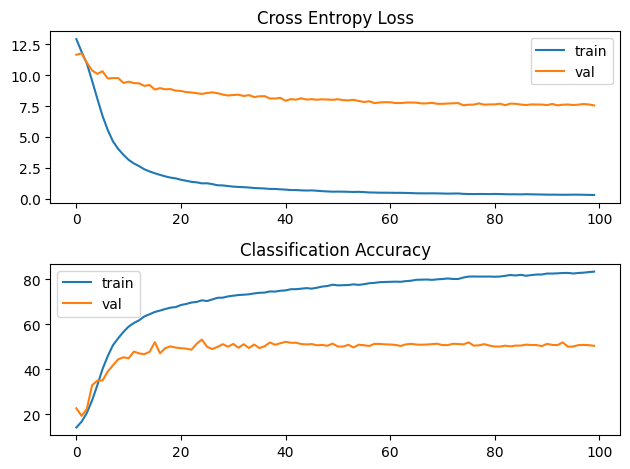

In [ ]:
plotTrainingHistory(train_history, val_history)

## Test the model

Evaluate the model in the test set

In [ ]:
# Load the best model
# TODO


# Evaluate model on test data
# TODO
#free cuda memory
torch.cuda.empty_cache()
def test(dataloader):
    preds = []
    labels = []
    with torch.no_grad():  # Disable gradient calculation
        for batch, (X, y) in enumerate(tqdm(dataloader)):
            X, y = X.to(device), y.to(device)

            # Compute prediction error
            pred = model(X)

            #probs = F.softmax(pred, dim=1)
            #final_pred = torch.argmax(probs, dim=1)
            predsTmp = pred.cpu()*12
            preds.append(predsTmp.cpu())
            #print(preds)
            #print(final_pred.cpu().numpy())
            #original_values =y.cpu().argmax(dim=-1) + 1
            labels.append(y.cpu())
        #print(labels.shape,preds.shape)
        all_preds = torch.cat(preds).round()
        all_labels = torch.cat(labels)
        #print("All preds shape:",all_preds.shape,"All labels shape:",all_labels.shape)
        accuracy, recall, precision, f1 = calculate_metrics(all_preds, all_labels)
        return accuracy, recall, precision, f1
accuracy, recall, precision, f1 = test(test_dataloader)
print(f"Test accuracy: {accuracy:.3f}, Test recall: {recall:.3f}, Test precision: {precision:.3f}, Test f1: {f1:.3f}")

100%|██████████| 142/142 [00:14<00:00,  9.87it/s]

[array([ 1,  2,  3,  5,  4,  3,  2,  1,  0,  0,  0,  0,  0,  0,  0,  0, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,  6,  6,  6,
        6,  6,  6,  6,  6,  7,  8,  9, 11, 10,  9,  8,  7])] [array([ 1,  2,  3,  5,  4,  3,  2,  1,  0,  0,  0,  0,  0,  0,  0,  0, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,  6,  6,  6,
        6,  6,  6,  6,  6,  7,  8,  9, 11, 10,  9,  8,  7])]
Test loss: 47.867


  0%|          | 0/142 [00:00<?, ?it/s]

[[ 1.  2.  3.  5.  4.  3.  2.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [12. 12. 12. 12. 12. 12. 12. 12.]
 [12. 12. 12. 12. 12. 12. 12. 12.]
 [12. 12. 12. 12. 12. 12. 12. 12.]
 [12. 12. 12. 12. 12. 12. 12. 12.]
 [ 6.  6.  6.  6.  6.  6.  6.  6.]
 [ 7.  8.  9. 11. 10.  9.  8.  7.]]
[[ 1  2  3  5  4  3  2  1]
 [ 0  0  0  0  0  0  0  0]
 [12 12 12 12 12 12 12 12]
 [12 12 12 12 12 12 12 12]
 [12 12 12 12 12 12 12 12]
 [12 12 12 12 12 12 12 12]
 [ 6  6  6  6  6  6  6  6]
 [ 7  8  9 11 10  9  8  7]]


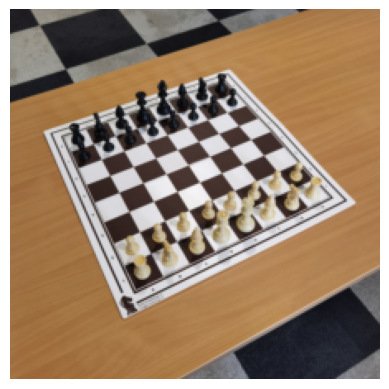

  0%|          | 0/142 [00:00<?, ?it/s]


In [ ]:
torch.cuda.empty_cache()
def results_analyse(dataloader):
    preds = []
    labels = []
    results = 5
    with torch.no_grad():  # Disable gradient calculation
        for batch, (X, y) in enumerate(tqdm(dataloader)):
            X, y = X.to(device), y.to(device)

            # Compute prediction error
            pred = model(X)

            #probs = F.softmax(pred, dim=1)
            #final_pred = torch.argmax(probs, dim=1)
            predsTmp = (pred.cpu()*12).round().int()
            print(predsTmp[0].reshape(8, 8))
            print(y.cpu()[0].reshape(8, 8))
            #print(pred.cpu().shape, y.cpu().shape)
            pred1 = (pred.cpu()*12).round().int()
            #print(pred1)
            accuracy, recall, precision, f1 = calculate_metrics(pred1, y.cpu())
            print(f"Accuracy: {accuracy:.3f}, Recall: {recall:.3f}, Precision: {precision:.3f}, F1: {f1:.3f}")
            #print(pred.cpu())
            #print(y.cpu())
            imgs = X.cpu()
            imgs = imgs.permute(0, 2, 3, 1)*torch.tensor([[[0.229, 0.224, 0.225]]]) + torch.tensor([[[0.485, 0.456, 0.406]]])
            plt.imshow(imgs[0])
            plt.axis('off')
            plt.show()
            results -= 1
            if results <0:
                break
results_analyse(test_dataloader)

## Challenge

In transfer learning, we often replace the head of the model (fully-connected layers responsible for classification) to fit the task. However, these new layers are not pre-trained and thus they contain an error that is backpropagated through the pre-trained part of the network during training. We can avoid this through a training strategy that is divided into two steps:
* Freeze the pre-trained layers of the network so that their parameters are no longer updated during training and train only the head of the model
* Unfreeze these layers and train the network as a whole.

Implement this strategy and see the results!

## For Group Project - Task 2: Adapt multiclass classification network to regression!

Now that you have a multiclass baseline, adapt the network for the regression problem, considering the following aspects:
* How many neurons should the last layer of a regression network have?
* What should be the final activation function for a regression network?
* What loss functions can be used to train a regression network?